In [1]:
using Arpack
using LinearAlgebra
using LaTeXStrings
using Revise
using PyPlot
using MeshGrid
includet("/Users/avadali/Desktop/Desktop - Avi's Mac/Summer2024/AHC_code/Lattice_setup/lattice_BZ.jl")
includet("/Users/avadali/Desktop/Desktop - Avi's Mac/Summer2024/AHC_code/3P_funcs/patch_methods.jl")
includet("/Users/avadali/Desktop/Desktop - Avi's Mac/Summer2024/AHC_code/3P_funcs/lambda_funcs.jl")

# Helper funcs

In [2]:
function approx_sign(x; tol=1e-13)
    if x > tol
        return 1
    elseif x < -tol
        return -1
    else
        return 0
    end
end
function grid_bc(grid, lambda, rs, kappa, V, shells, index, spacing)
    num_vertices = 4

    mBZ_count = num_mBZ(shells)
    shell_parts = sgn_parts(shells)
    partitions = sgn_parts(shells - 1)
    part_1s = sgn_parts(1)
    dict = part_dict(shells)

    ham = zeros(ComplexF64, mBZ_count, mBZ_count)
    spinors = Array{ComplexF64}(undef, num_vertices, mBZ_count, 2)
    grounds = Array{ComplexF64}(undef, num_vertices, mBZ_count)
    plaq_area = area(spacing * sqrt(2), num_vertices)

    g1 = kappa * sqrt(3) * [-sqrt(3)/2, 1/2]
    g2 = kappa * sqrt(3) * [0, 1]

    gi = zeros(2)
    gj = zeros(2)

    berry_list = Array{Float64}(undef, size(grid, 1))

    for i in 1:size(grid, 1)
        berry_list[i] = lambda_mBZ_bc!(g1, g2, num_vertices, plaq_area, shell_parts, partitions, part_1s, dict, ham, spinors, grounds, 
        grid[i, :], lambda, rs, kappa, V, shells, index, spacing)
    end
    return berry_list
end
function plot_bc(lambda, rs, kappa, V, shells, index, spacing)
    n_pts = 10^2

    k_list = range(-kappa, kappa, n_pts)
    grid = mesh_grid(k_list, k_list, Float64)


    bc_list = grid_bc(grid, lambda, rs, kappa, V, shells, index, spacing)

    grid_new = reshape(grid, (n_pts, n_pts, 2))
    bc_list_new = reshape(bc_list, (n_pts, n_pts))

    bc_min = minimum(bc_list_new)
    bc_max = maximum(bc_list_new)
    bc_abs = maximum(abs.([bc_min, bc_max]))

    figure()
    xlabel(L"k_x")
    ylabel(L"k_y")
    title(L"\Omega(k_x, k_y) \text{ vs } (k_x, k_y)")
    pcolormesh(grid_new[:, :, 1], grid_new[:, :, 2], bc_list_new, cmap="RdBu", vmin = -bc_abs, vmax = bc_abs)
    colorbar()
    display(gcf())
end

plot_bc (generic function with 1 method)

# Hamiltonian setup

In [3]:
function lambda_epsilon_v3(k, n, kappa, gap, vF)
    return (2/n) * vF * sqrt(1 + abs2(gap)) * kappa * sqrt((norm(k)/kappa)^n + abs2(gap))
end
function lambda_ham_v3!(g1, g2, shell_parts, partitions, part_1s, dict, ham, k, lambda, n, gap, vF, V)
    kappa = norm(g2)/sqrt(3)
    # connect all lower order mBZ's to their nn
    for i in 1:length(partitions)
        part_i = partitions[i]
        idex = dict[part_i]
        for j in 1:7
            part_j = part_1s[j]
            gi = part_i[1] * g1 + part_i[2] * g2
            gj = gi .+ part_j[1] * g1 + part_j[2] * g2
            jdex = dict[part_i .+ part_j]
            if part_j != (0, 0)
                val = 1/2 * lambda_ff(V, lambda, k .+ gi, k .+ gj)
                ham[idex, jdex] = val
                ham[jdex, idex] = conj(val)
            end
        end
    end
    # connect outside ring of mBZ's together
    outer_ring = setdiff(shell_parts, partitions)
    for i in 1:length(outer_ring)
        part_i = outer_ring[i]
        idex = dict[part_i]
        for j in 1:7
            part_j = part_1s[j]
            gi = part_i[1] * g1 + part_i[2] * g2
            gj = gi .+ part_j[1] * g1 + part_j[2] * g2
            if (part_i .+ part_j) in outer_ring && part_j != (0, 0)
                jdex = dict[part_i .+ part_j]
                val = 1/2 * lambda_ff(V, lambda, k .+ gi, k .+ gj)
                ham[idex, jdex] = val
                ham[jdex, idex] = conj(val)
            end
        end
    end
    # add in kinetic terms
    for i in 1:length(shell_parts)
        part = shell_parts[i]
        idex = dict[part]
        gi = part[1] * g1 + part[2] * g2
        ham[idex, idex] = lambda_epsilon_v3(gi .+ k, n, kappa, gap, vF)
    end
    return ham
end
function lambda_ham_v3(k, lambda, n, gap, vF, kappa, V, shells)
    mBZ_count = num_mBZ(shells)
    ham = zeros(ComplexF64, mBZ_count, mBZ_count)
    shell_parts = sgn_parts(shells)
    partitions = sgn_parts(shells - 1)
    part_1s = sgn_parts(1)
    dict = part_dict(shells)
    g1 = kappa * sqrt(3) * [-sqrt(3)/2, 1/2]
    g2 = kappa * sqrt(3) * [0, 1]
    lambda_ham_v3!(g1, g2, shell_parts, partitions, part_1s, dict, ham, k, lambda, n, gap, vF, V)
end
function lambda_mBZ_bc_v3(k, lambda, n, gap, vF, kappa, V, shells, index, spacing)
    num_vertices = 4

    g1 = kappa * sqrt(3) * [-sqrt(3)/2, 1/2]
    g2 = kappa * sqrt(3) * [0, 1]

    mBZ_count = num_mBZ(shells)
    shell_parts = sgn_parts(shells)
    partitions = sgn_parts(shells - 1)
    part_1s = sgn_parts(1)
    dict = part_dict(shells)

    ham = zeros(ComplexF64, mBZ_count, mBZ_count)
    
    spinors = Array{ComplexF64}(undef, num_vertices, mBZ_count, 2)
    grounds = Array{ComplexF64}(undef, num_vertices, mBZ_count)

    plaq_area = area(spacing * sqrt(2), num_vertices)
    lambda_mBZ_bc_v3!(g1, g2, num_vertices, plaq_area, shell_parts, partitions, part_1s, dict, ham, spinors, grounds, k, 
    lambda, n, gap, vF, kappa, V, shells, index, spacing)
end
function lambda_mBZ_bc_v3!(g1, g2, num_vertices, plaq_area, shell_parts, partitions, part_1s, dict, ham, spinors, grounds, k, lambda, n, gap, vF, kappa, V, shells, index, spacing)
    for j in 1:num_vertices
        x_new = k[1] + spacing * cos(2 * pi * (j - 1) / num_vertices)
        y_new = k[2] + spacing * sin(2 * pi * (j - 1) / num_vertices)
        ham = lambda_ham_v3!(g1, g2, shell_parts, partitions, part_1s, dict, ham, [x_new, y_new], lambda, n, gap, vF, V)
        grounds[j, :] = gauge_fix(normalize(eigvecs(Hermitian(ham))[:, index]))
        for m in 1:length(shell_parts)
            momentum = g1 * shell_parts[m][1] + g2 * shell_parts[m][2] + [x_new, y_new]
            spinors[j, m, :] = lambda_spinor(lambda, momentum)
        end
    end
    P = 1
    for j in 1:num_vertices
        if j < num_vertices
            temp = spinor_inner(grounds[j, :], grounds[j + 1, :], spinors[j, :, :], spinors[j + 1, :, :])
            P *= temp / abs(temp)
        else
            temp = spinor_inner(grounds[j, :], grounds[1, :], spinors[j, :, :], spinors[1, :, :])
            P *= temp / abs(temp)
        end
    end
    if abs(imag(P)) < 10^(-16)
        return -(angle(real(P))) / plaq_area
    else
        return -angle(P) / plaq_area
    end
end
function grid_bc_v3(grid, lambda, n, gap, vF, kappa, V, shells, index, spacing)
    num_vertices = 4

    mBZ_count = num_mBZ(shells)
    shell_parts = sgn_parts(shells)
    partitions = sgn_parts(shells - 1)
    part_1s = sgn_parts(1)
    dict = part_dict(shells)

    ham = zeros(ComplexF64, mBZ_count, mBZ_count)
    spinors = Array{ComplexF64}(undef, num_vertices, mBZ_count, 2)
    grounds = Array{ComplexF64}(undef, num_vertices, mBZ_count)
    plaq_area = area(spacing * sqrt(2), num_vertices)

    g1 = kappa * sqrt(3) * [-sqrt(3)/2, 1/2]
    g2 = kappa * sqrt(3) * [0, 1]

    gi = zeros(2)
    gj = zeros(2)

    berry_list = Array{Float64}(undef, size(grid, 1))

    for i in 1:size(grid, 1)
        berry_list[i] = lambda_mBZ_bc_v3!(g1, g2, num_vertices, plaq_area, shell_parts, partitions, part_1s, dict, ham, spinors, grounds, 
        grid[i, :], lambda, n, gap, vF, kappa, V, shells, index, spacing)
    end
    return berry_list
end

grid_bc_v3 (generic function with 1 method)

# Gaps

In [4]:
function plot_gap_lambda_v3(q, n, gap_list, vF, kappa, V, shells, llm, ulm)
    lambda_list = range(llm, ulm, 10^2)
    gaps = Array{Float64}(undef, length(lambda_list), length(gap_list))
    for i in 1:length(lambda_list)
        lambda = lambda_list[i]
        q1 = kappa * [1, 0]
        for j in 1:length(gap_list)
            gap = gap_list[j]
            ham = lambda_ham_v3(q1, lambda, n, gap, vF, kappa, V, shells)
            vals = eigvals(Hermitian(ham))
            gaps[i, j] = log10(vals[2] - vals[1])
        end
    end
    fig, axs = plt.subplots(1,1,figsize=(15, 8))
    axs.set_xlabel(L"$\lambda$")
    axs.set_ylabel(L"$\log|\epsilon_0 - \epsilon_1|$")
    axs.set_title(L"$\log|\epsilon_0 - \epsilon_1|_{n} \text{ vs } \lambda$")
    for j in 1:length(gap_list)
        d = round(gap_list[j], sigdigits=2)
        axs.plot(lambda_list, gaps[:, j], label = raw"$d = $" * "$d")
    end
    axs.legend()
    fig
end

plot_gap_lambda_v3 (generic function with 1 method)

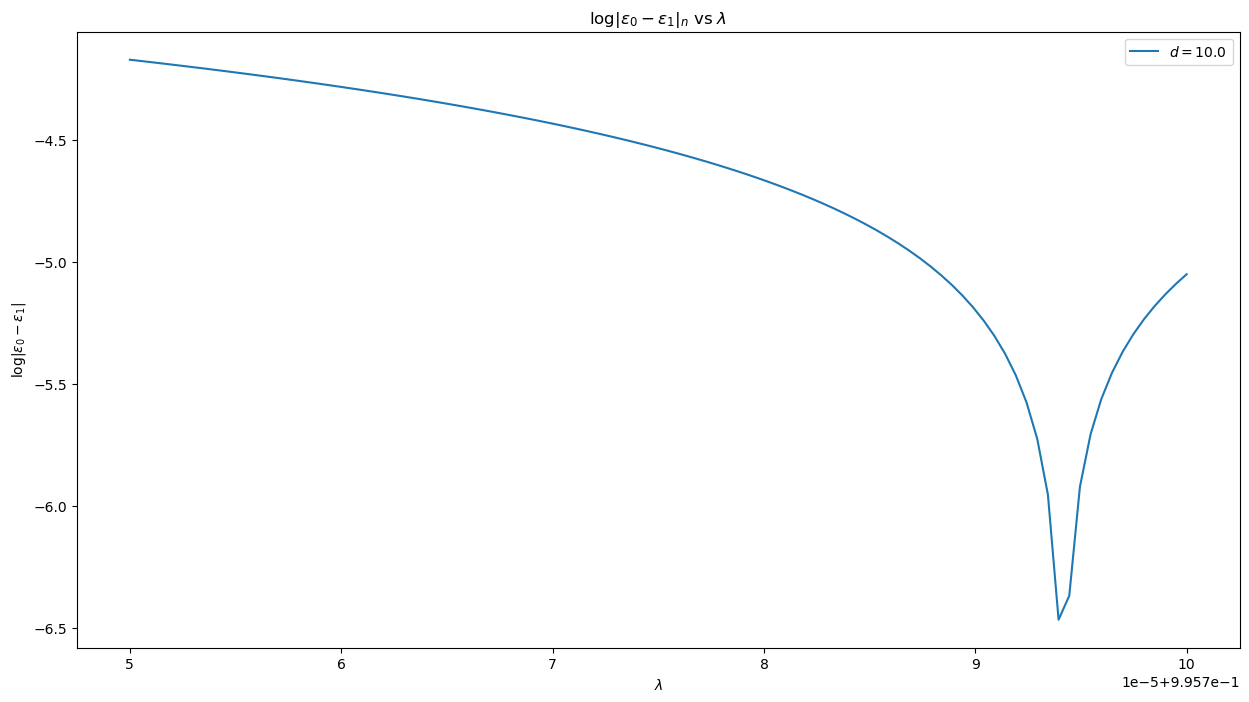

In [1257]:
# set the relevant parameters
q = [0, 0]
n = 10
gap_list = [10]
vF = 0.7457
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
llm = 0.99575
ulm = 0.99580
plot_gap_lambda_v3(q, n, gap_list, vF, kappa, V, shells, llm, ulm)

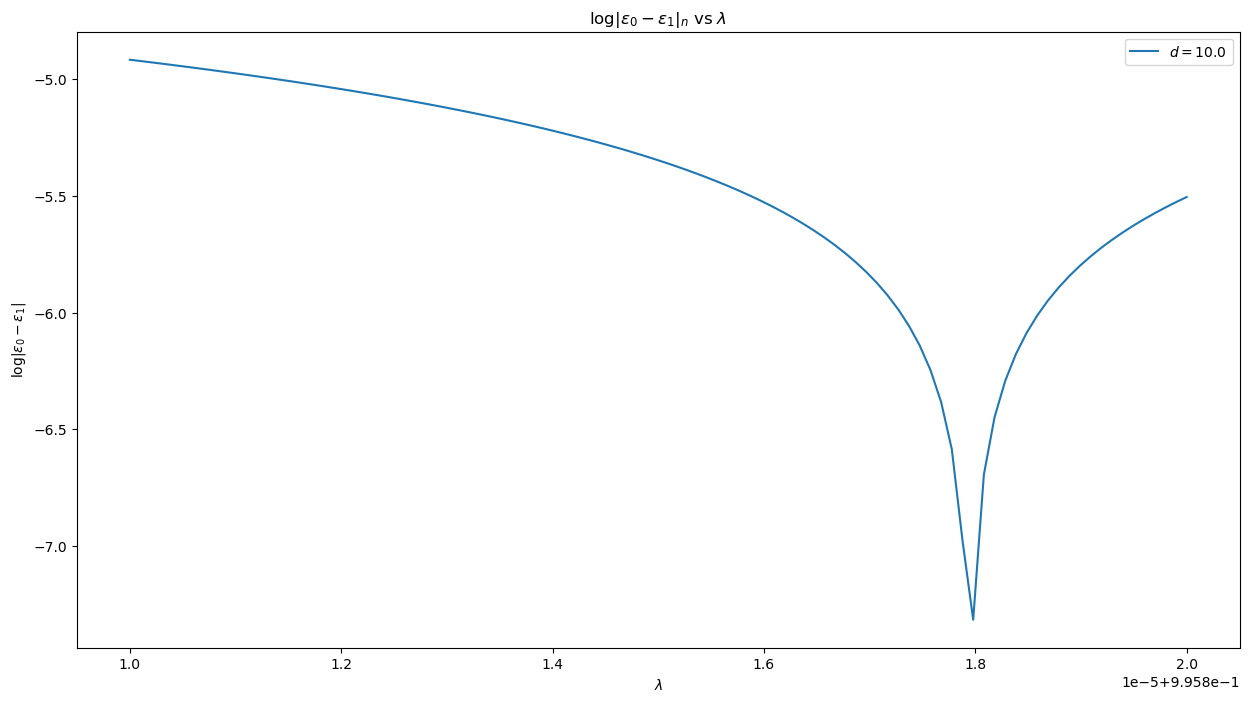

In [1305]:
# set the relevant parameters
q = [0, 0]
n = 10
gap_list = [10]
vF = 0.75
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
llm = 0.99581
ulm = 0.99582
plot_gap_lambda_v3(q, n, gap_list, vF, kappa, V, shells, llm, ulm)

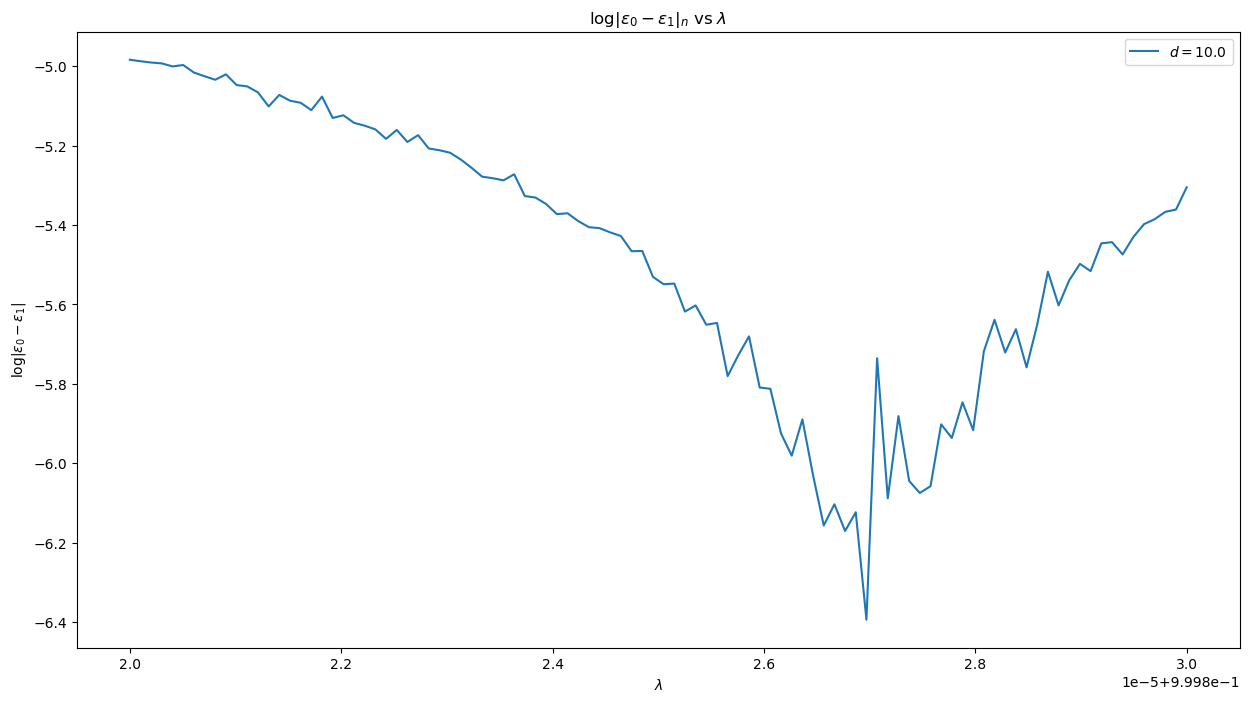

In [1198]:
# set the relevant parameters
q = [0, 0]
n = 20
gap_list = [10]
vF = 0.85
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
llm = 0.99982
ulm = 0.99983
plot_gap_lambda_v3(q, n, gap_list, vF, kappa, V, shells, llm, ulm)

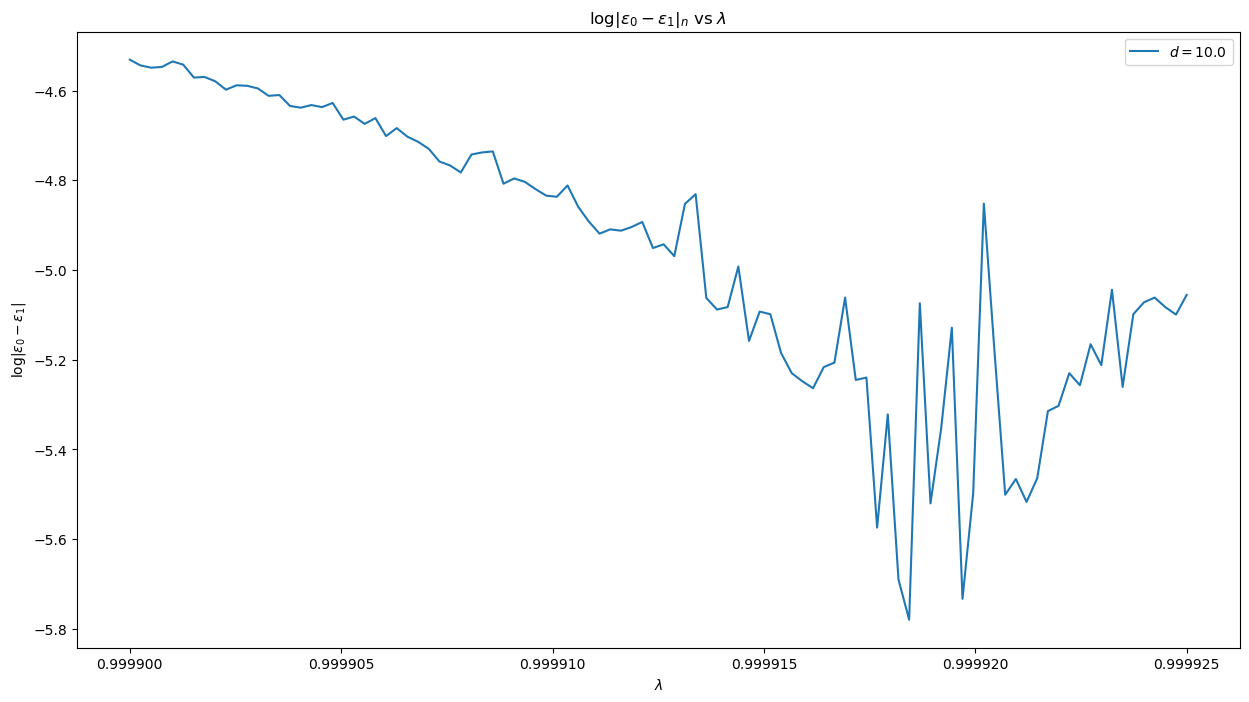

In [1035]:
# set the relevant parameters
q = [0, 0]
n = 22
gap_list = [10]
vF = 1
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
llm = 0.9999
ulm = 0.999925
plot_gap_lambda_v3(q, n, gap_list, vF, kappa, V, shells, llm, ulm)

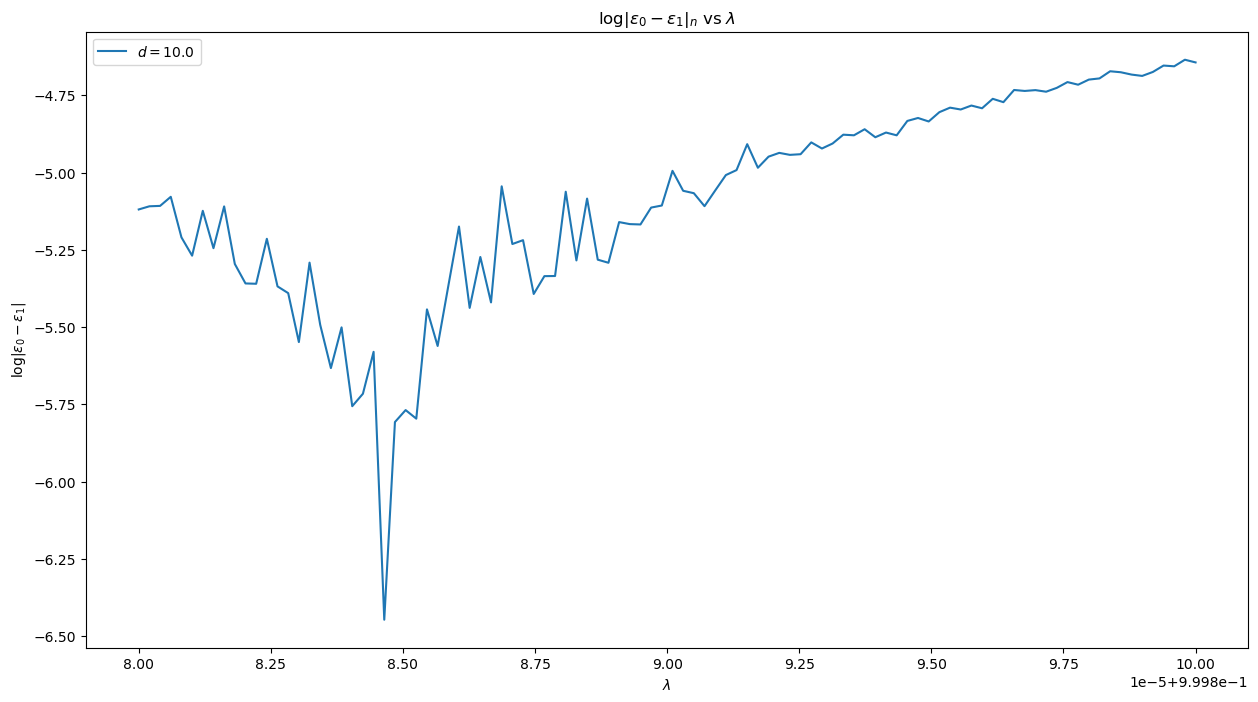

In [914]:
# set the relevant parameters
q = [0, 0]
n = 22
gap_list = [10]
vF = 0.7
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
llm = 0.99988
ulm = 0.99990
plot_gap_lambda_v3(q, n, gap_list, vF, kappa, V, shells, llm, ulm)

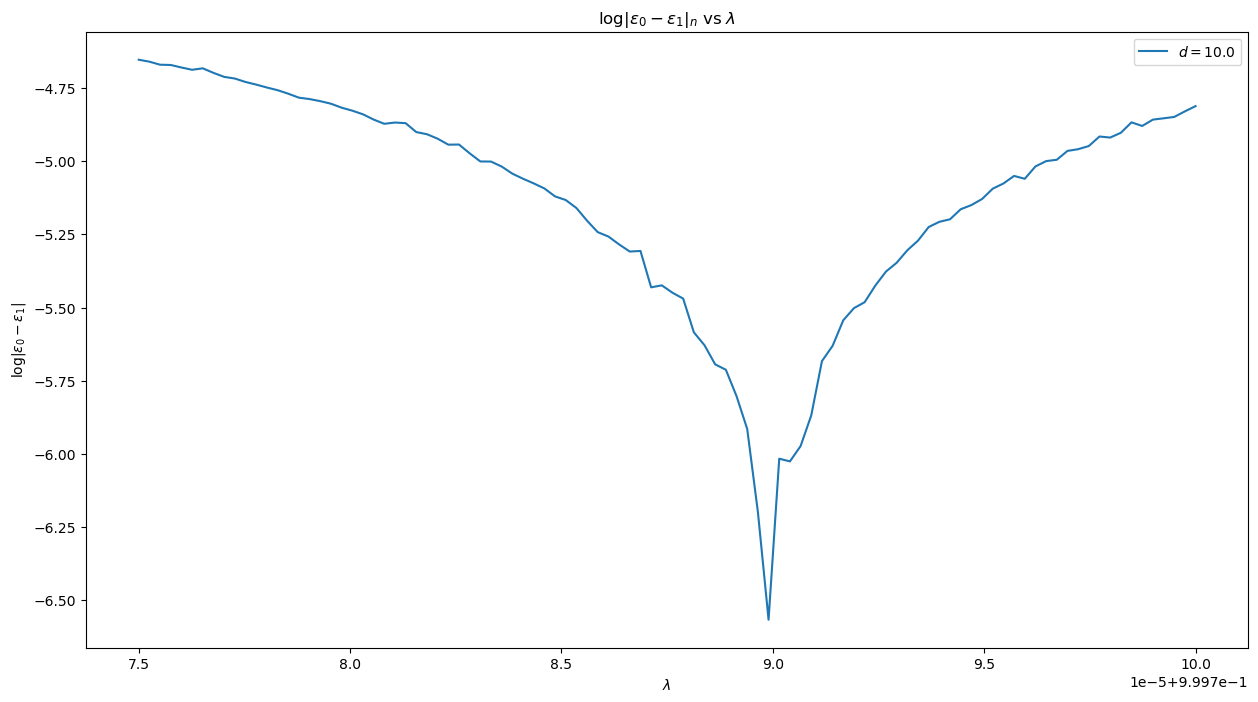

In [903]:
# set the relevant parameters
q = [0, 0]
n = 20
gap_list = [10]
vF = 0.7
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
llm = 0.999775
ulm = 0.999800
plot_gap_lambda_v3(q, n, gap_list, vF, kappa, V, shells, llm, ulm)

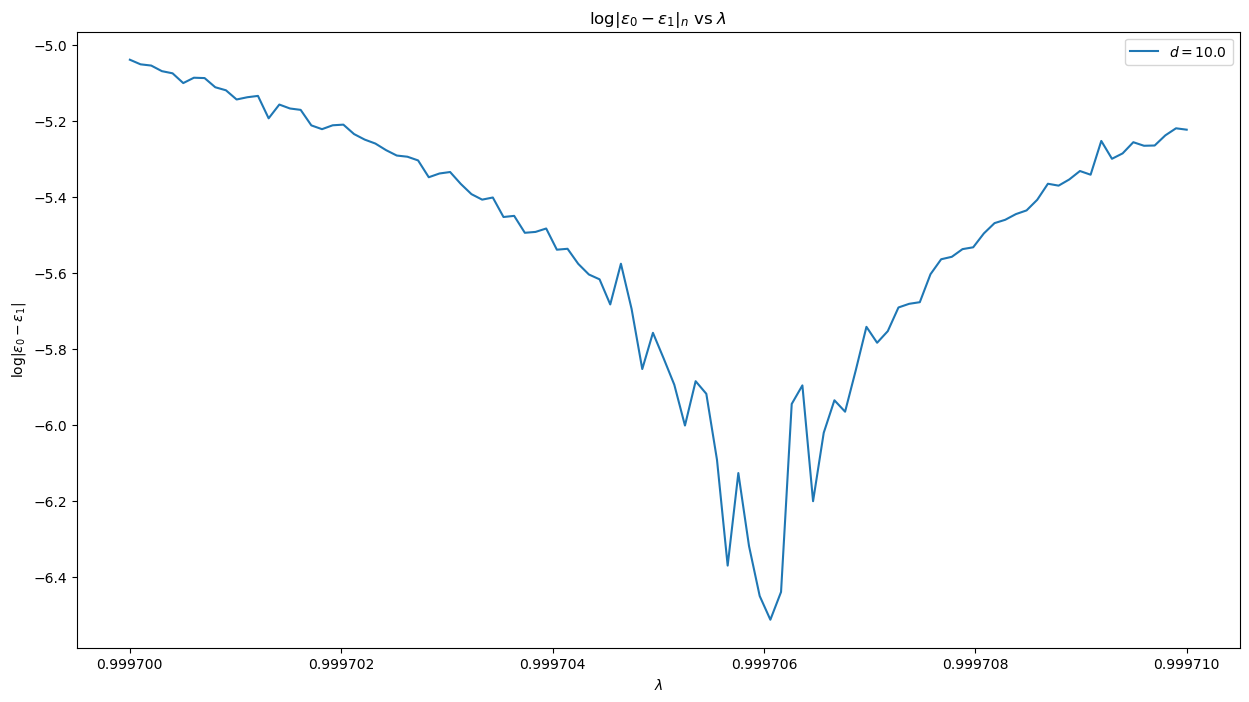

In [897]:
# set the relevant parameters
q = [0, 0]
n = 20
gap_list = [10]
vF = 0.5
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
llm = 0.99970
ulm = 0.99971
plot_gap_lambda_v3(q, n, gap_list, vF, kappa, V, shells, llm, ulm)

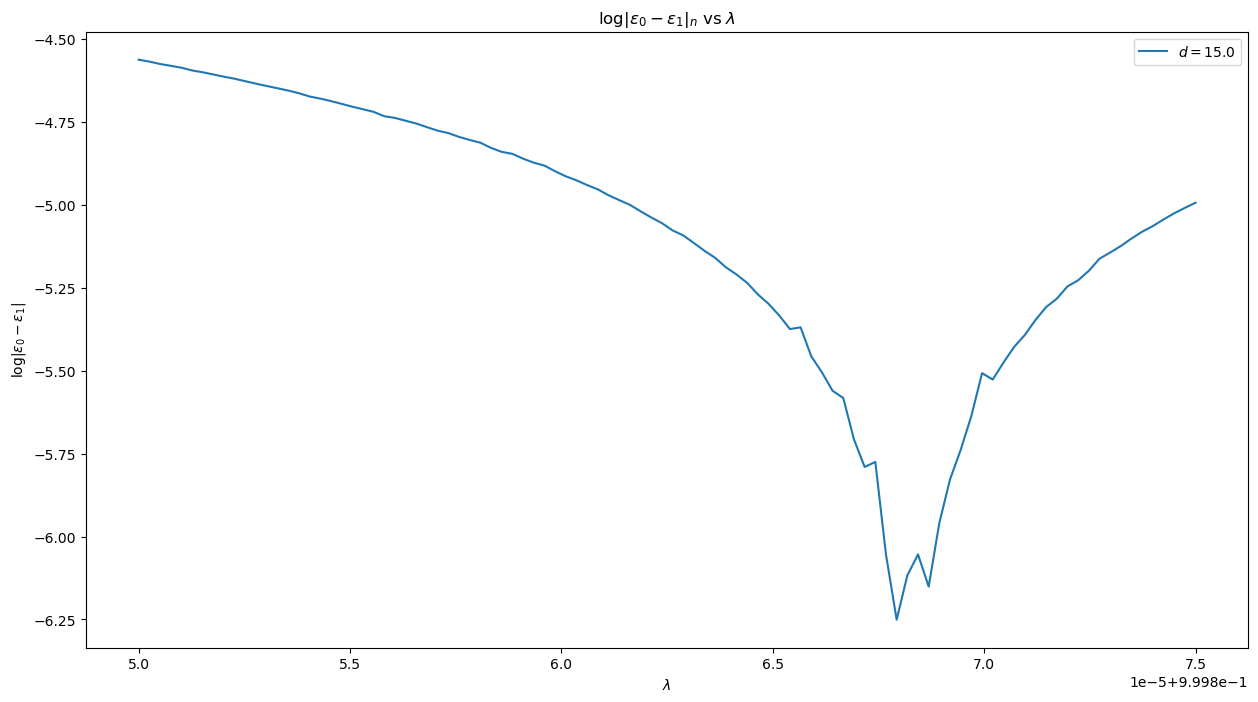

In [855]:
# set the relevant parameters
q = [0, 0]
n = 20
gap_list = [15]
vF = 0.75
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
llm = 0.99985
ulm = 0.999875
plot_gap_lambda_v3(q, n, gap_list, vF, kappa, V, shells, llm, ulm)

# Some vF thoughts

In [658]:
function plot_gap_vF_v3(q, n, gap_list, lambda, kappa, V, shells, llm, ulm)
    vF_list = range(llm, ulm, 10^2)
    gaps = Array{Float64}(undef, length(vF_list), length(gap_list))
    for i in 1:length(vF_list)
        vF = vF_list[i]
        q1 = kappa * [1, 0]
        for j in 1:length(gap_list)
            gap = gap_list[j]
            ham = lambda_ham_v3(q1, lambda, n, gap, vF, kappa, V, shells)
            vals = eigvals(Hermitian(ham))
            gaps[i, j] = log10(vals[2] - vals[1])
        end
    end
    fig, axs = plt.subplots(1,1,figsize=(15, 8))
    axs.set_xlabel(L"$v_F$")
    axs.set_ylabel(L"$\log|\epsilon_0 - \epsilon_1|$")
    axs.set_title(L"$\log|\epsilon_0 - \epsilon_1|_{n} \text{ vs } v_F$")
    for j in 1:length(gap_list)
        d = round(gap_list[j], sigdigits=2)
        axs.plot(vF_list, gaps[:, j], label = raw"$d = $" * "$d")
    end
    axs.legend()
    fig
end

plot_gap_vF_v3 (generic function with 1 method)

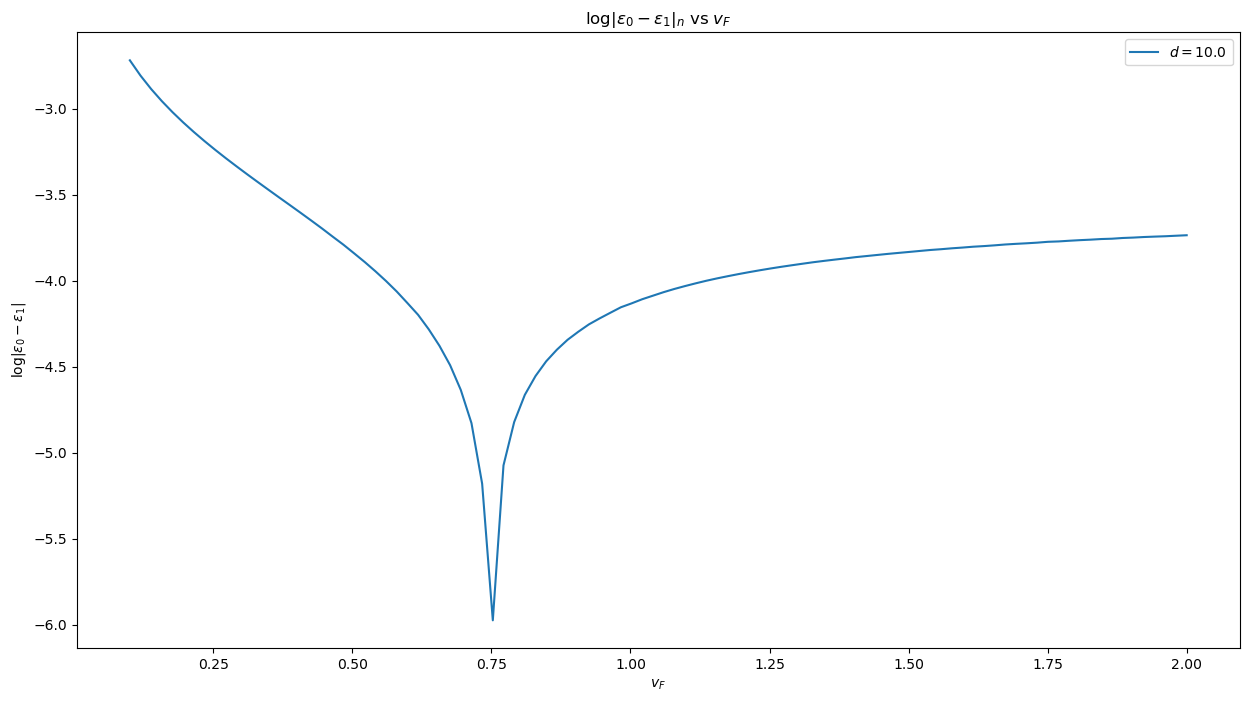

In [830]:
# set the relevant parameters
q = [0, 0]
n = 20
gap_list = [10]
lambda = 0.999804
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
llm = 0.1
ulm = 2
plot_gap_vF_v3(q, n, gap_list, lambda, kappa, V, shells, llm, ulm)

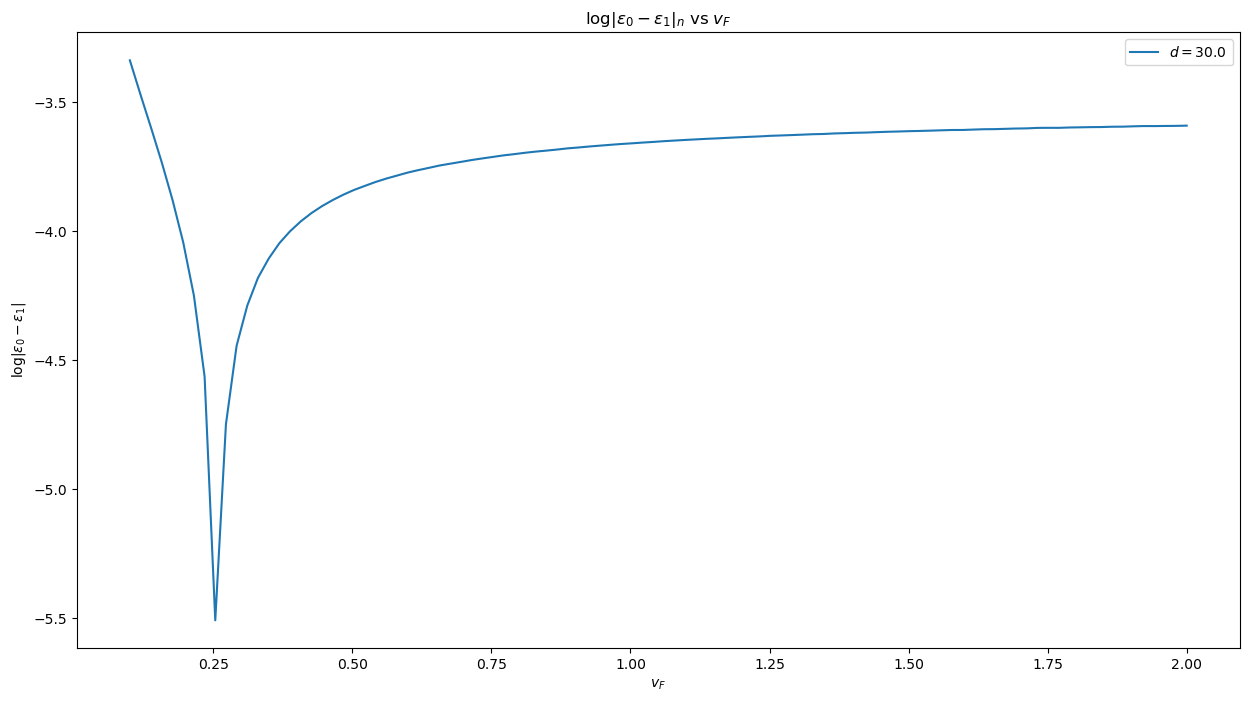

In [828]:
# set the relevant parameters
q = [0, 0]
n = 20
gap_list = [30]
lambda = 0.999804
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
llm = 0.1
ulm = 2
plot_gap_vF_v3(q, n, gap_list, lambda, kappa, V, shells, llm, ulm)

# Band structure

In [5]:
function plot_energy_line_v3(lambda, n, gap, vF, kappa, V, shells, spacing, ky, llm, ulm)
    n_pts = 10^2

    kx_list = range(llm, ulm, n_pts)

    energies = Array{Float64}(undef, n_pts, 3)

    for j in 1:(n_pts)
        k = [kx_list[j], ky]
        ham = lambda_ham_v3(k, lambda, n, gap, vF, kappa, V, shells)
        energies[j, 1] = eigvals(Hermitian(ham))[1]
        energies[j, 2] = eigvals(Hermitian(ham))[2]
        energies[j, 3] = eigvals(Hermitian(ham))[3]
    end

    fig, axs = plt.subplots(1,figsize=(12, 8))
    axs.set_xlabel(L"$k_x$")
    axs.set_ylabel(L"$\epsilon$")
    axs.plot(kx_list, energies[:, 1], label = L"\epsilon_0")
    axs.plot(kx_list, energies[:, 2], label = L"\epsilon_1")
    #axs.plot(kx_list, energies[:, 3], label = L"\epsilon_2")
    axs.legend()
    fig.tight_layout()
    
    fig
end

plot_energy_line_v3 (generic function with 1 method)

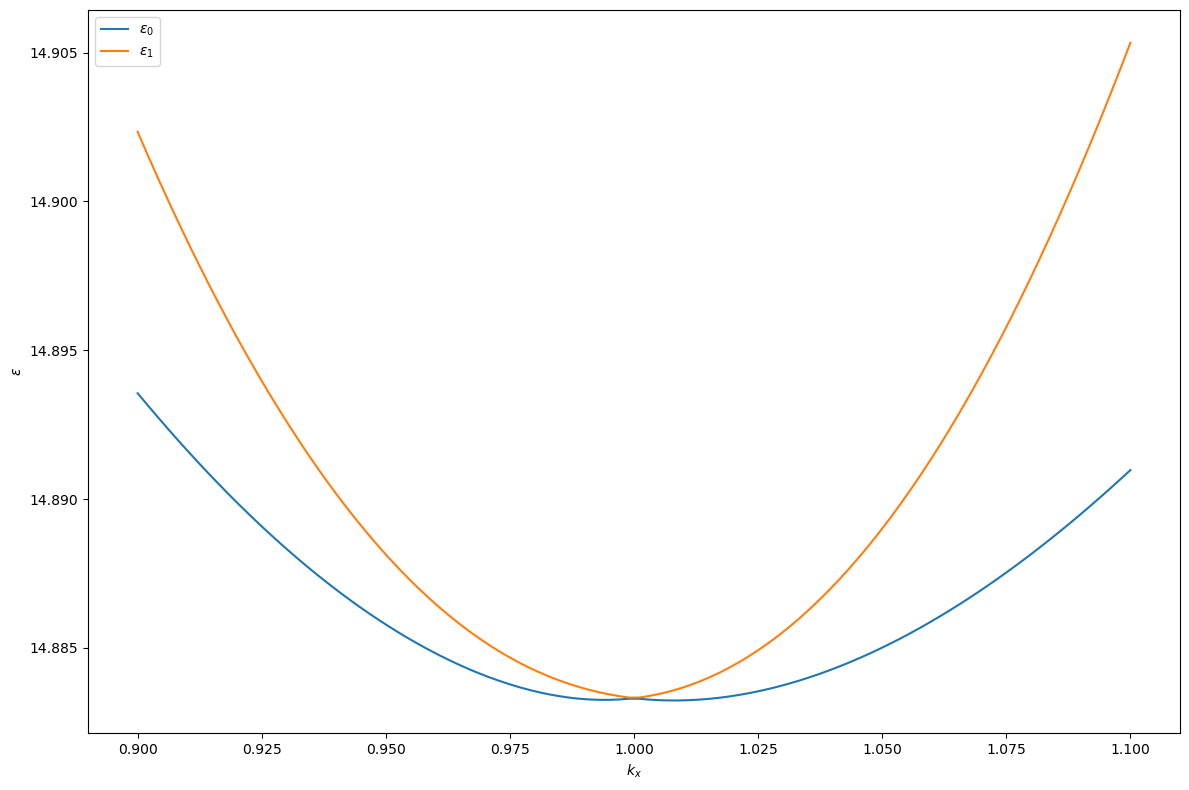

In [1308]:
# set the relevant parameters
lambda = 0.995818
n = 10
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
bc_spacing = 10^(-6)
ky = 0
llm = 0.9
ulm = 1.1
gap = 10

# alpha = 0.5 * lambda_alpha(kappa, lambda, V[1, 1], V[2, 2])
vF = 3/4

plot_energy_line_v3(lambda, n, gap, vF, kappa, V, shells, bc_spacing, ky, llm, ulm)

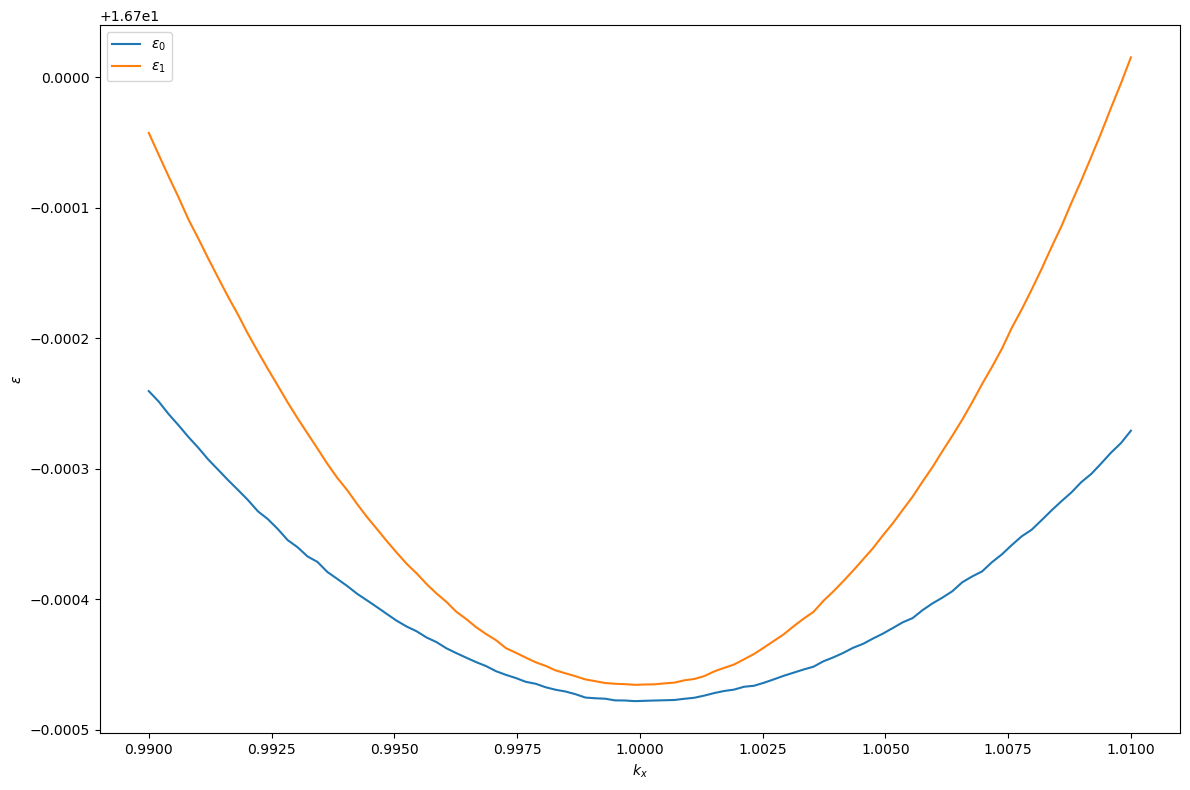

In [1310]:
# set the relevant parameters
lambda = 0.999860
n = 20
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
bc_spacing = 10^(-6)
ky = 0
llm = 0.99
ulm = 1.01
gap = 15

# alpha = 0.5 * lambda_alpha(kappa, lambda, V[1, 1], V[2, 2])
vF = 3/4

plot_energy_line_v3(lambda, n, gap, vF, kappa, V, shells, bc_spacing, ky, llm, ulm)

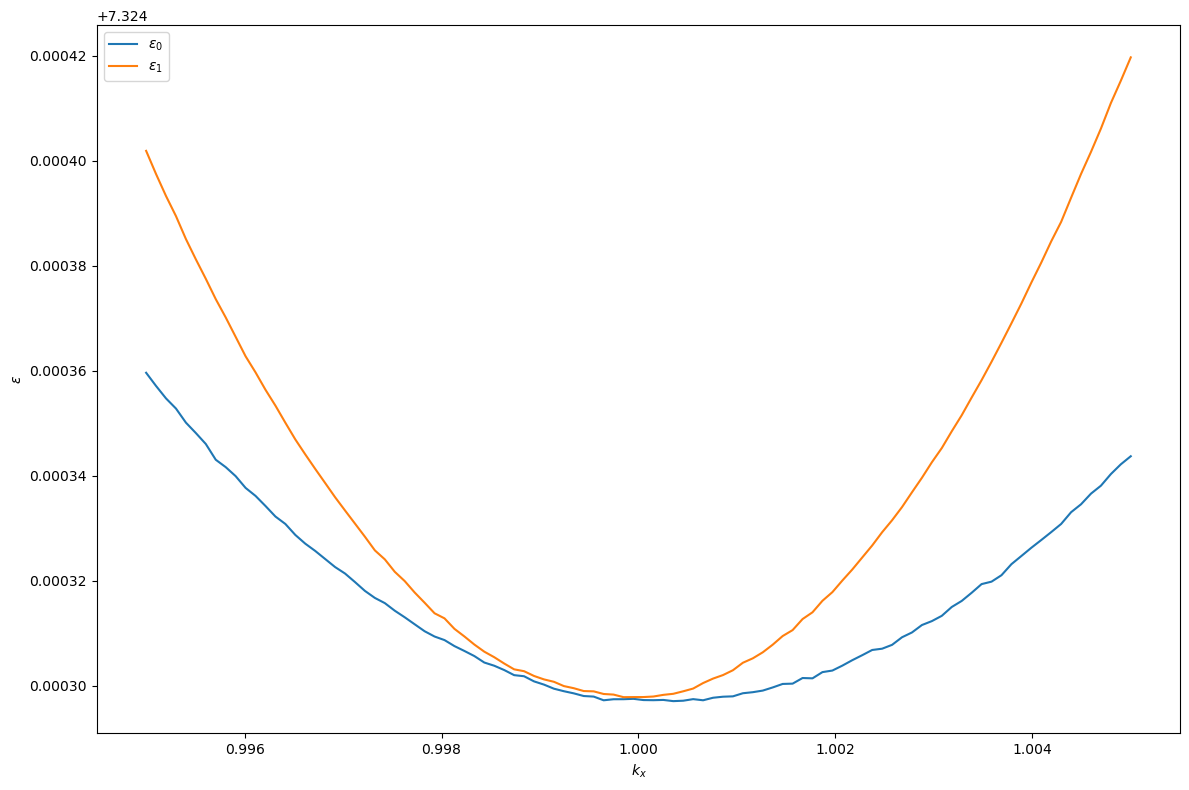

In [1171]:
# set the relevant parameters
lambda = 0.999804
n = 20
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
bc_spacing = 10^(-6)
ky = 0
llm = 0.995
ulm = 1.005
gap = 10

# alpha = 0.5 * lambda_alpha(kappa, lambda, V[1, 1], V[2, 2])
vF = 0.75

plot_energy_line_v3(lambda, n, gap, vF, kappa, V, shells, bc_spacing, ky, llm, ulm)

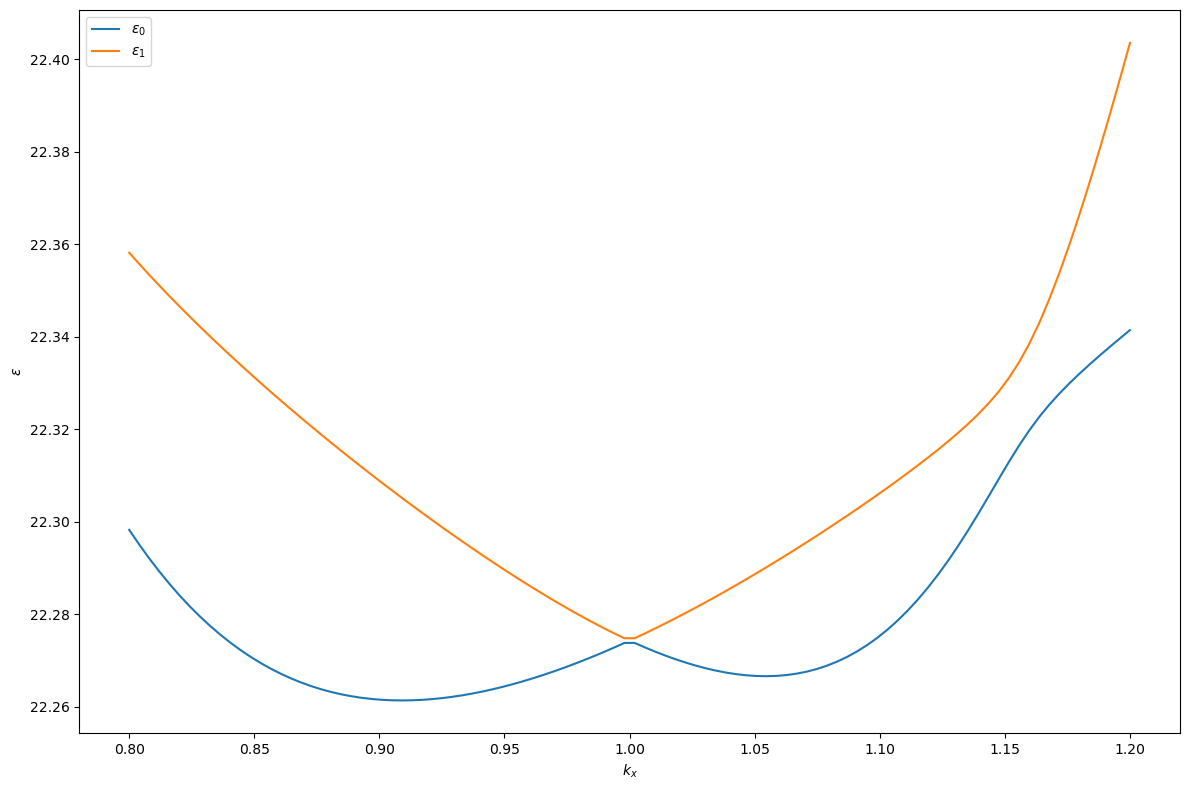

In [973]:
# set the relevant parameters
lambda = 0.999804
n = 20
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
bc_spacing = 10^(-6)
ky = 0
llm = 0.8
ulm = 1.2
gap = 30

# alpha = 0.5 * lambda_alpha(kappa, lambda, V[1, 1], V[2, 2])
vF = 0.25

plot_energy_line_v3(lambda, n, gap, vF, kappa, V, shells, bc_spacing, ky, llm, ulm)

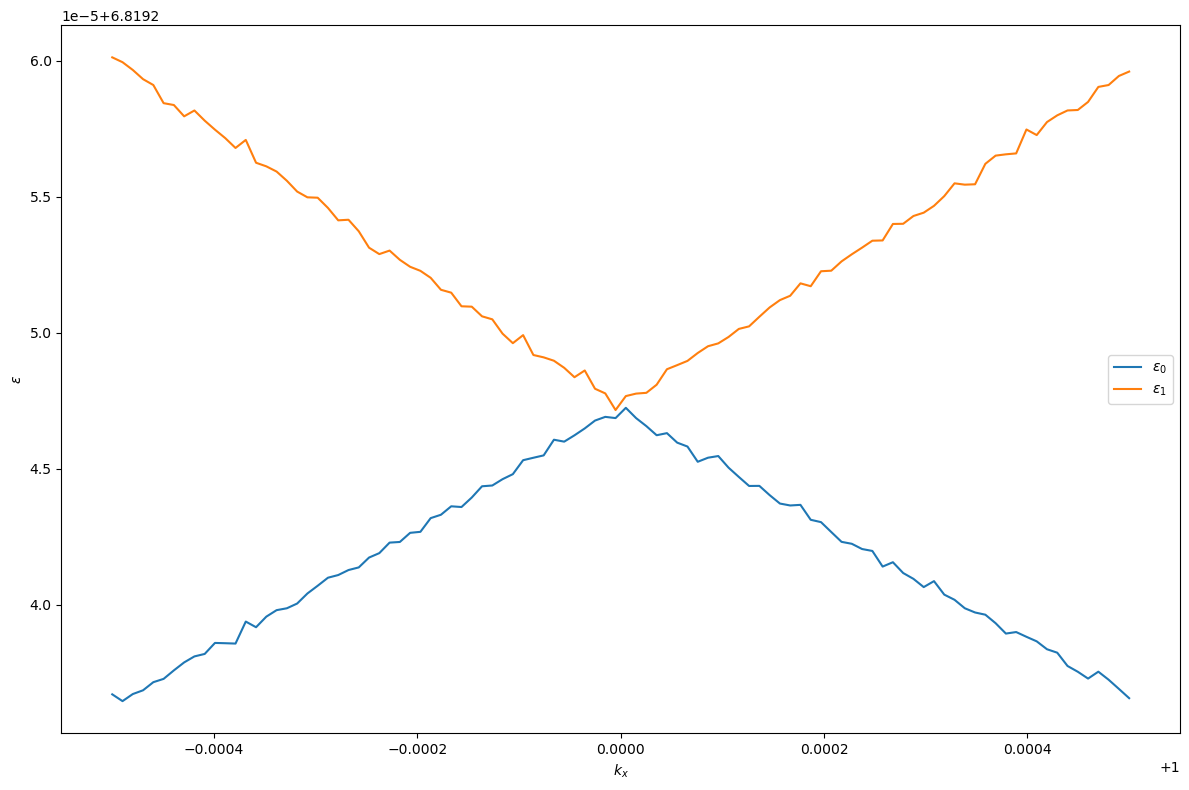

In [999]:
# set the relevant parameters
lambda = 0.99979
n = 20
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
bc_spacing = 10^(-6)
ky = 0
llm = 0.9995
ulm = 1.0005
gap = 10

# alpha = 0.5 * lambda_alpha(kappa, lambda, V[1, 1], V[2, 2])
vF = 0.7

plot_energy_line_v3(lambda, n, gap, vF, kappa, V, shells, bc_spacing, ky, llm, ulm)

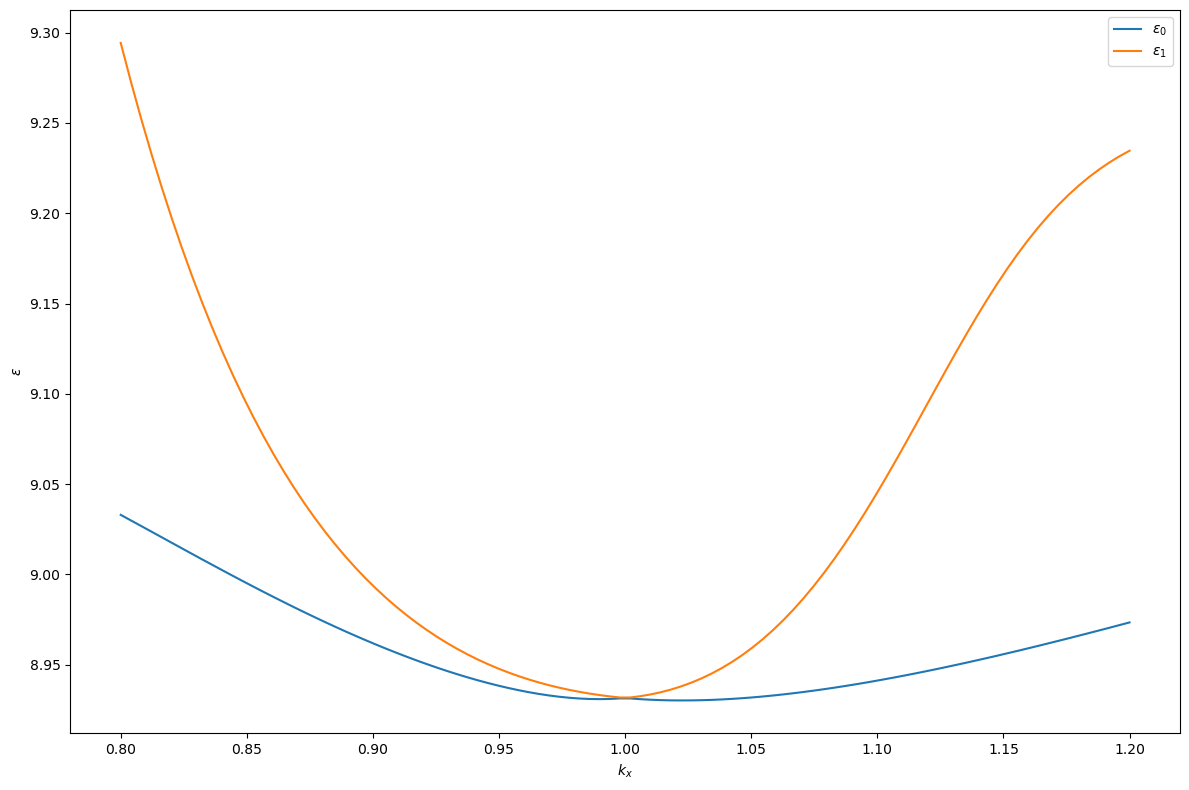

In [1201]:
# set the relevant parameters
lambda = 0.999917
n = 22
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
bc_spacing = 10^(-6)
ky = 0
llm = 0.8
ulm = 1.2
gap = 10

# alpha = 0.5 * lambda_alpha(kappa, lambda, V[1, 1], V[2, 2])
vF = 1

plot_energy_line_v3(lambda, n, gap, vF, kappa, V, shells, bc_spacing, ky, llm, ulm)

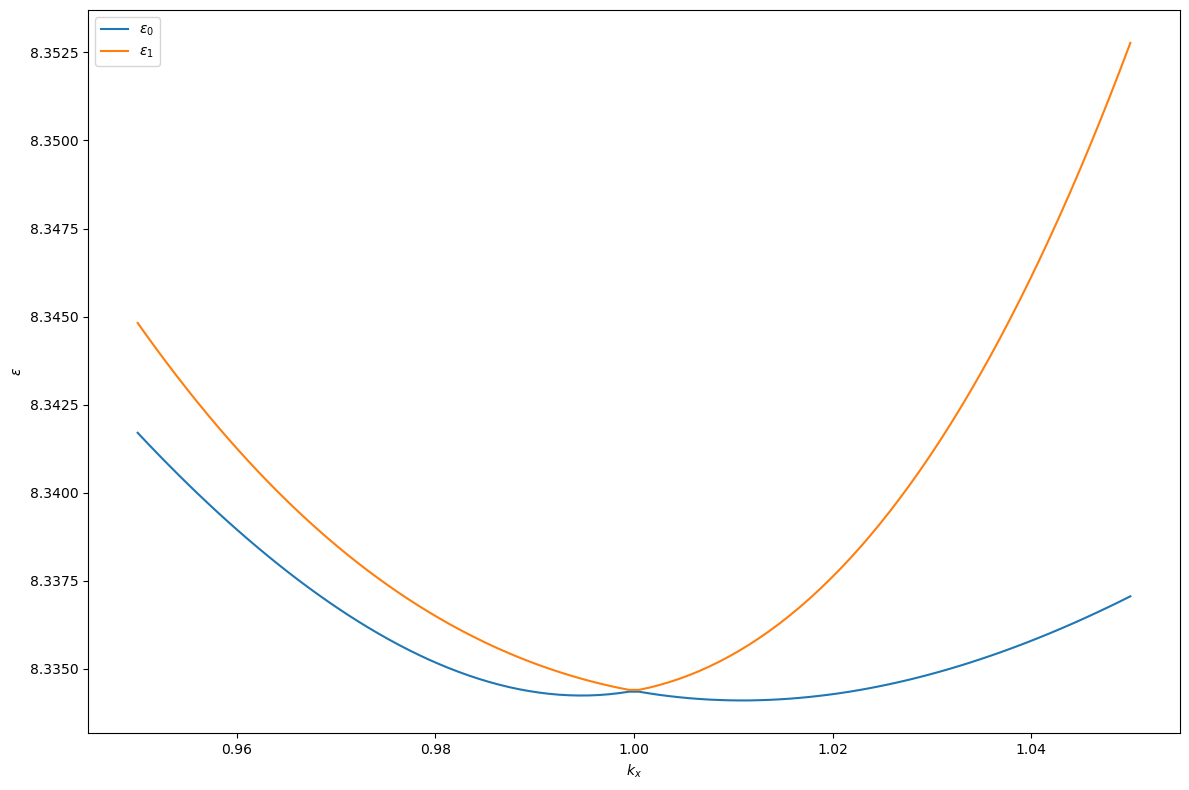

In [1202]:
# set the relevant parameters
lambda = 0.999827
n = 20
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
bc_spacing = 10^(-6)
ky = 0
llm = 0.95
ulm = 1.05
gap = 10

# alpha = 0.5 * lambda_alpha(kappa, lambda, V[1, 1], V[2, 2])
vF = 0.85

plot_energy_line_v3(lambda, n, gap, vF, kappa, V, shells, bc_spacing, ky, llm, ulm)

In [1286]:
function plot_energy_ang_v3(lambda, n, gap, vF, kappa, V, shells, spacing, mag)
    n_pts = 10^2

    ang_list = range(-pi, pi, n_pts)

    energies = Array{Float64}(undef, n_pts, 3)

    for j in 1:(n_pts)
        k = [kappa, 0] + mag * [cos(ang_list[j]), sin(ang_list[j])]
        ham = lambda_ham_v3(k, lambda, n, gap, vF, kappa, V, shells)
        energies[j, 1] = eigvals(Hermitian(ham))[1]
        energies[j, 2] = eigvals(Hermitian(ham))[2]
        energies[j, 3] = eigvals(Hermitian(ham))[3]
    end

    fig, axs = plt.subplots(1,figsize=(12, 8))
    axs.set_xlabel(L"$\theta/ \pi$")
    axs.set_ylabel(L"$\epsilon$")
    axs.plot(ang_list/pi, energies[:, 1], label = L"\epsilon_0")
    #axs.plot(ang_list/pi, energies[:, 2], label = L"\epsilon_1")
    #axs.plot(ang_list/pi, energies[:, 3], label = L"\epsilon_2")
    axs.legend()
    fig.tight_layout()
    
    fig
end

plot_energy_ang_v3 (generic function with 1 method)

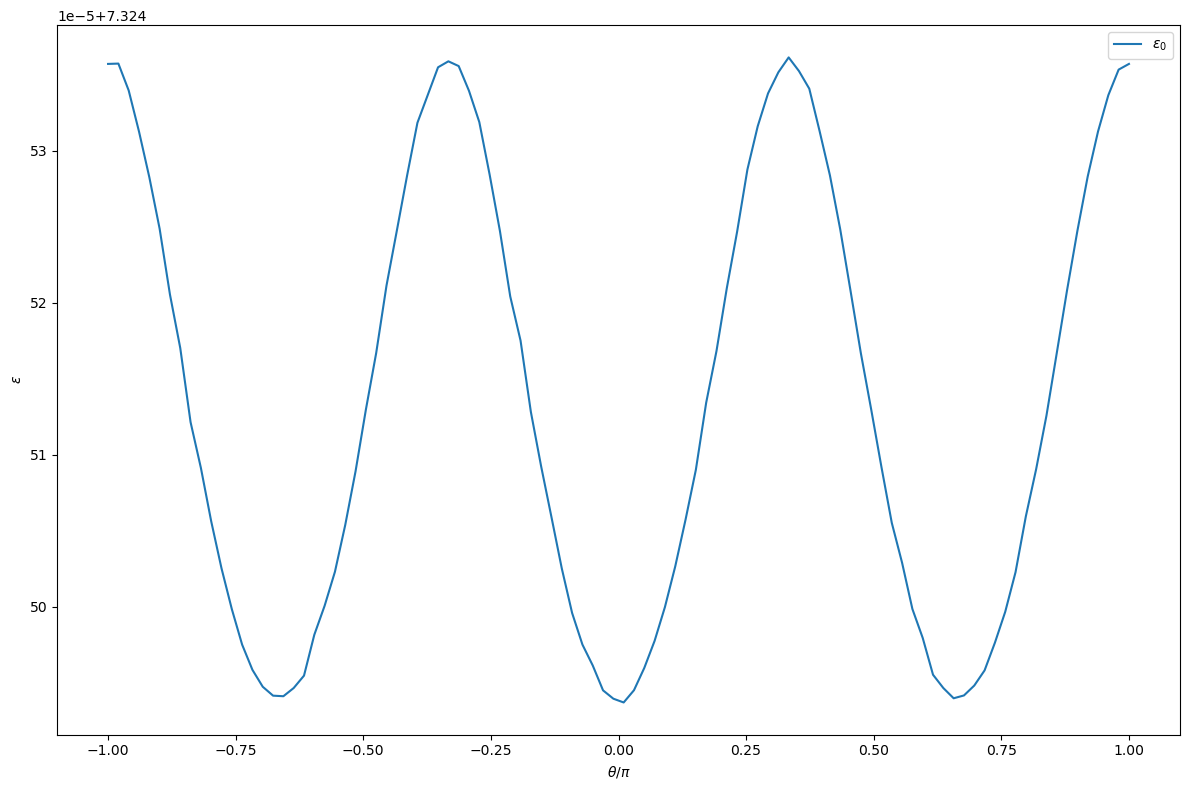

In [1287]:
# set the relevant parameters
lambda = 0.999804
n = 20
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
bc_spacing = 10^(-6)
gap = 10

# alpha = 0.5 * lambda_alpha(kappa, lambda, V[1, 1], V[2, 2])
vF = 0.75
mag = 0.01

plot_energy_ang_v3(lambda, n, gap, vF, kappa, V, shells, bc_spacing, mag)

#plot_energy_line_v3(lambda, n, gap, vF, kappa, V, shells, bc_spacing, ky, llm, ulm)

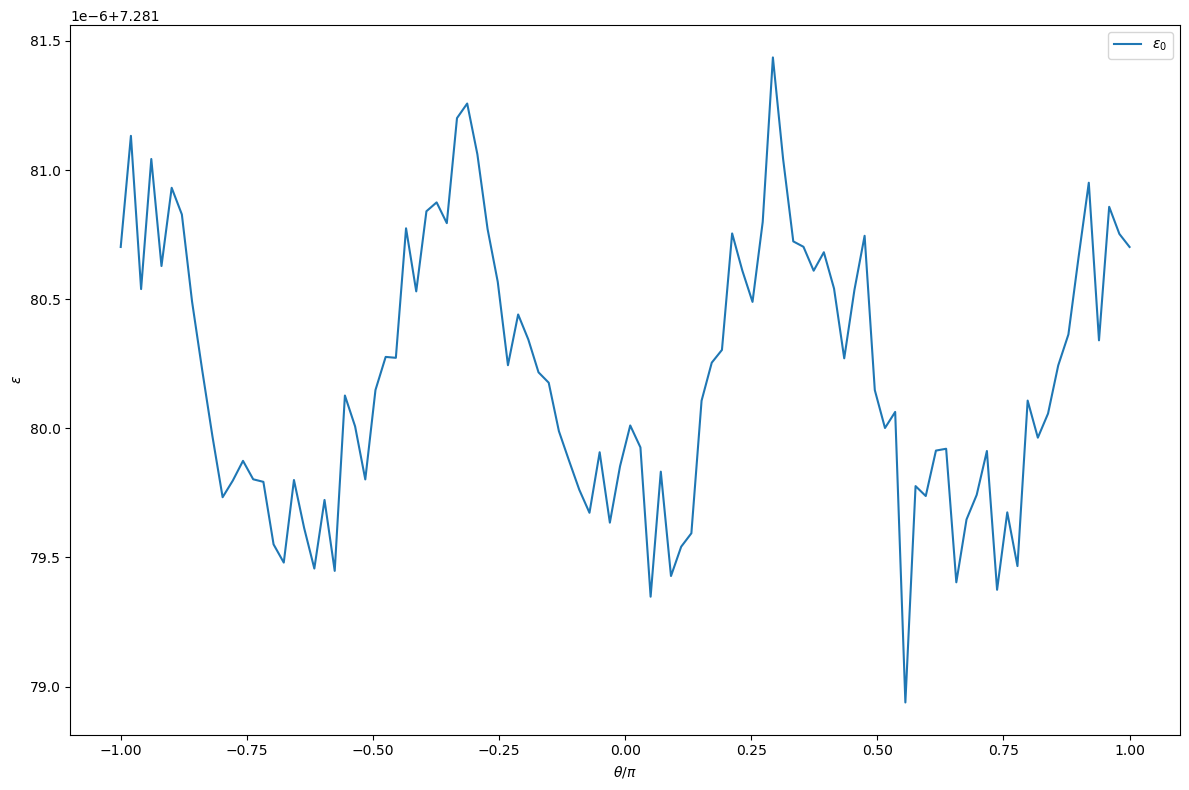

In [1288]:
# set the relevant parameters
lambda = 0.999804
n = 20
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
bc_spacing = 10^(-6)
gap = 10

# alpha = 0.5 * lambda_alpha(kappa, lambda, V[1, 1], V[2, 2])
vF = 0.7457
mag = 0.01

plot_energy_ang_v3(lambda, n, gap, vF, kappa, V, shells, bc_spacing, mag)

#plot_energy_line_v3(lambda, n, gap, vF, kappa, V, shells, bc_spacing, ky, llm, ulm)

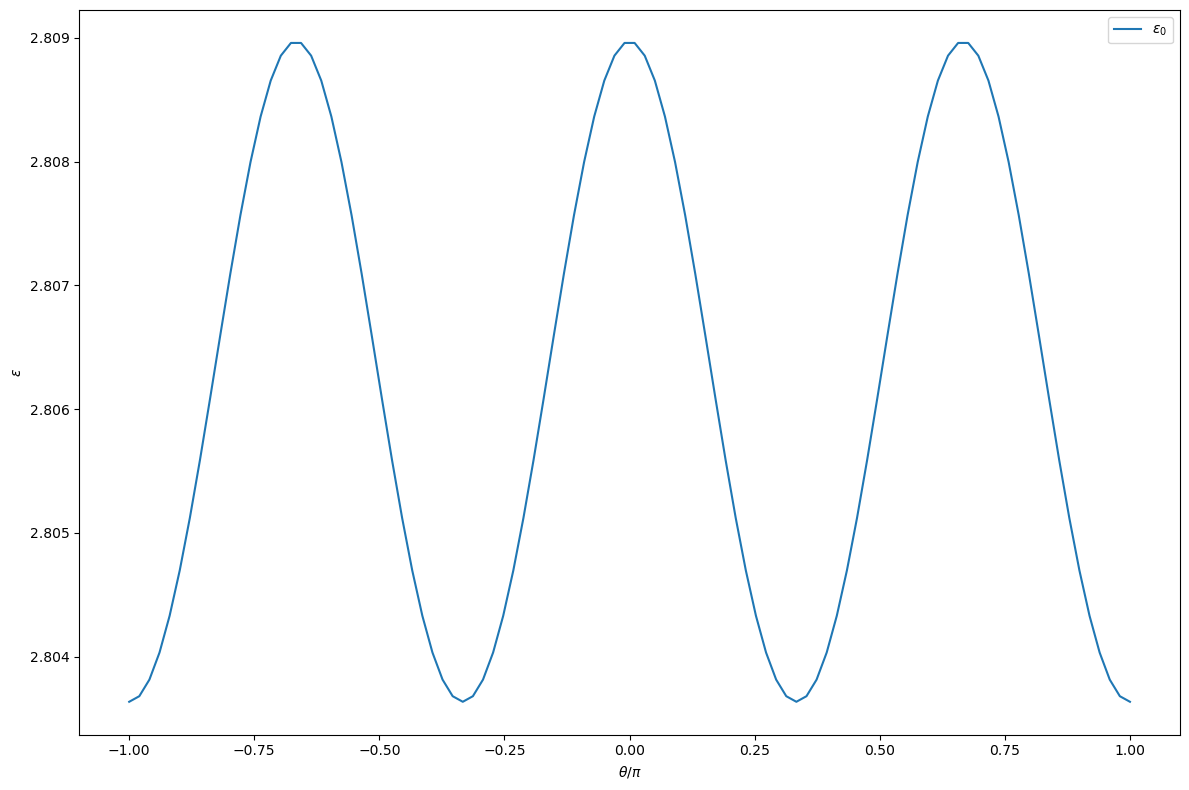

In [1289]:
# set the relevant parameters
lambda = 0.999579
n = 10
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
bc_spacing = 10^(-6)
gap = 10

# alpha = 0.5 * lambda_alpha(kappa, lambda, V[1, 1], V[2, 2])
vF = 0.7457
mag = 0.01

plot_energy_ang_v3(lambda, n, vF, gap, kappa, V, shells, bc_spacing, mag)

#plot_energy_line_v3(lambda, n, gap, vF, kappa, V, shells, bc_spacing, ky, llm, ulm)

## Slopes

In [592]:
function energy_slope_v3(lambda, n, gap, vF, kappa, V, shells, ky, kx, index, dmu)

    ham0 = lambda_ham_v3([kx, ky], lambda, n, gap, vF, kappa, V, shells)
    eg0 = eigvals(Hermitian(ham0))[index]

    ham1 = lambda_ham_v3([kx + dmu, ky], lambda, n, gap, vF, kappa, V, shells)
    eg1 = eigvals(Hermitian(ham1))[index]

    return (eg1 - eg0) / dmu
end
function plot_energy_slopes_v3(lambda, n, gap, vF, kappa, V, shells, spacing, ky, dmu, llm, ulm)
    n_pts = 10^2

    kx_list = range(llm, ulm, n_pts)

    slopes = Array{Float64}(undef, n_pts, 3)

    for j in 1:(n_pts)
        kx = kx_list[j]
        slopes[j, 1] = energy_slope_v3(lambda, n, gap, vF, kappa, V, shells, ky, kx, 1, dmu)
        slopes[j, 2] = energy_slope_v3(lambda, n, gap, vF, kappa, V, shells, ky, kx, 2, dmu)
        slopes[j, 3] = energy_slope_v3(lambda, n, gap, vF, kappa, V, shells, ky, kx, 3, dmu)
    end

    fig, axs = plt.subplots(1,figsize=(12, 8))
    axs.set_xlabel(L"$k_x$")
    axs.set_ylabel(L"$\frac{d\epsilon}{d k_x}$")
    axs.plot(kx_list, slopes[:, 1], label = L"0")
    axs.plot(kx_list, slopes[:, 2], label = L"1")
    #axs.plot(kx_list, slopes[:, 3], label = L"2")
    axs.legend()
    fig.tight_layout()
    
    fig
end

plot_energy_slopes_v3 (generic function with 1 method)

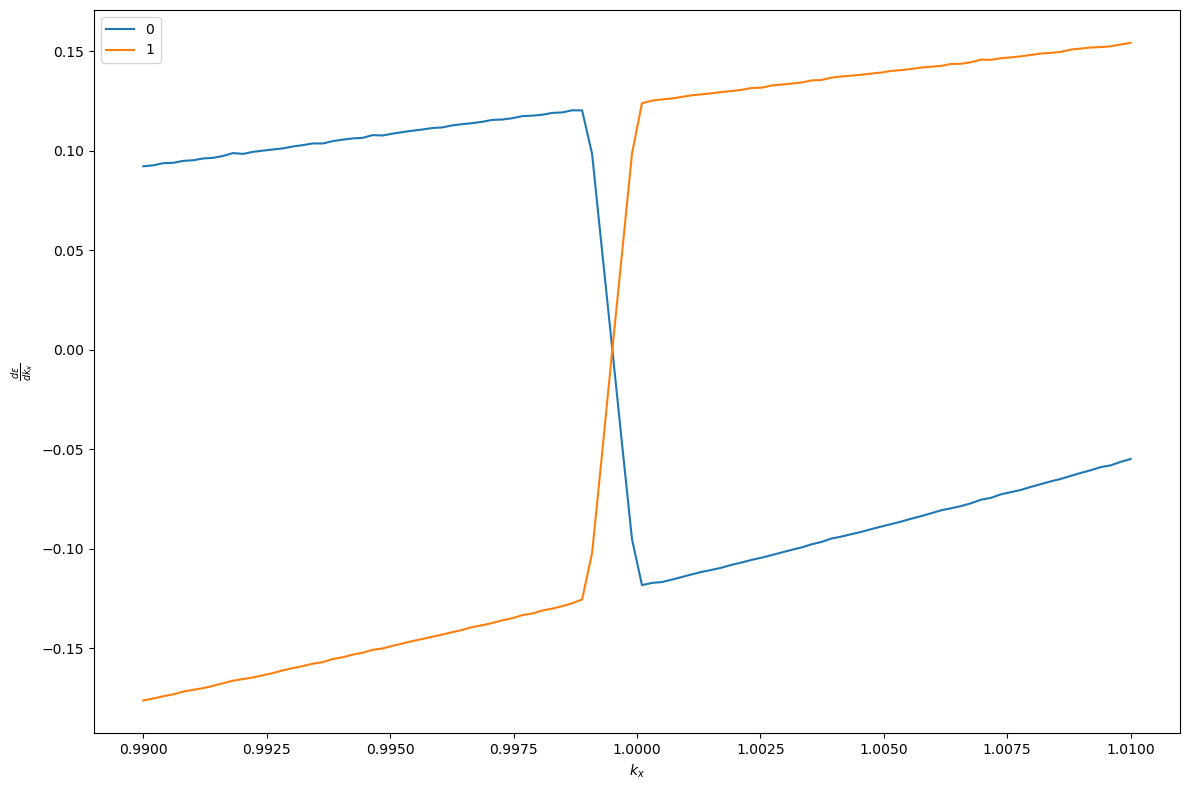

In [802]:
# set the relevant parameters
lambda = 1 - 0.0003
n = 20
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
bc_spacing = 10^(-4)
ky = 0
llm = 0.99
ulm = 1.01
gap = 10
dmu = 10^(-3)
# alpha = 0.5 * lambda_alpha(kappa, lambda, V[1, 1], V[2, 2])
# vF = -2 * real(exp(im * 2 * pi/3) * alpha)
vF = 0.5

plot_energy_slopes_v3(lambda, n, gap, vF, kappa, V, shells, bc_spacing, ky, dmu, llm, ulm)

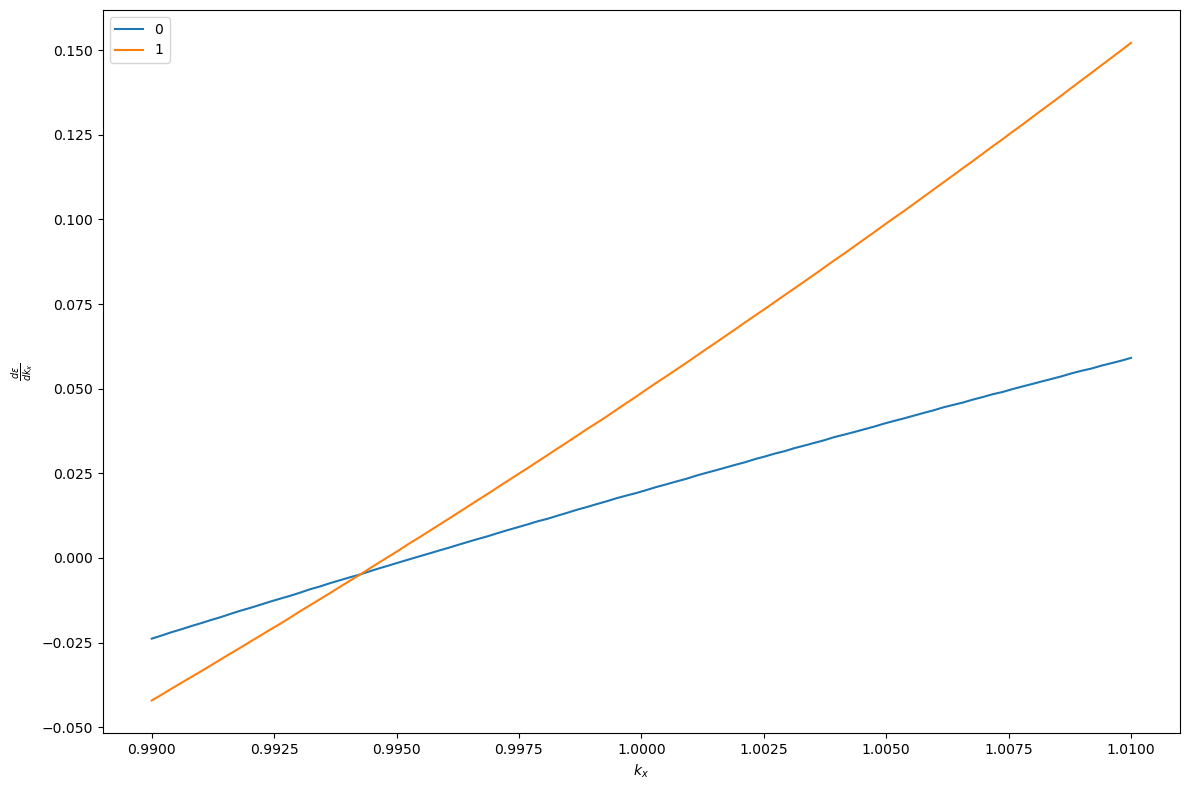

In [738]:
# set the relevant parameters
lambda = 0.999804
n = 20
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
bc_spacing = 10^(-4)
ky = 0
llm = 0.99
ulm = 1.01
gap = 10
dmu = 10^(-2)
# alpha = 0.5 * lambda_alpha(kappa, lambda, V[1, 1], V[2, 2])
# vF = -2 * real(exp(im * 2 * pi/3) * alpha)
vF = 3/4

plot_energy_slopes_v3(lambda, n, gap, vF, kappa, V, shells, bc_spacing, ky, dmu, llm, ulm)

# Berry phase around node

In [1267]:
function plot_bc_v3(lambda, n, vF, gap, kappa, V, shells, index, spacing, shift)
    n_pts = 10^2
    
    kx_list = range(kappa - shift, kappa + shift, n_pts)
    ky_list = shift * range(-1, 1, n_pts)
    grid = mesh_grid(kx_list, ky_list, Float64)

    # k_list = range(-kappa, kappa, n_pts)
    # grid = mesh_grid(k_list, k_list, Float64)


    bc_list = grid_bc_v3(grid, lambda, n, gap, vF, kappa, V, shells, index, spacing)

    grid_new = reshape(grid, (n_pts, n_pts, 2))
    bc_list_new = reshape(bc_list, (n_pts, n_pts))

    bc_min = minimum(bc_list_new)
    bc_max = maximum(bc_list_new)
    bc_abs = maximum(abs.([bc_min, bc_max]))

    figure()
    xlabel(L"k_x")
    ylabel(L"k_y")
    title(L"\Omega(k_x, k_y) \text{ vs } (k_x, k_y)")
    pcolormesh(grid_new[:, :, 1], grid_new[:, :, 2], bc_list_new, cmap="RdBu")
    colorbar()
    display(gcf())
end

plot_bc_v3 (generic function with 2 methods)

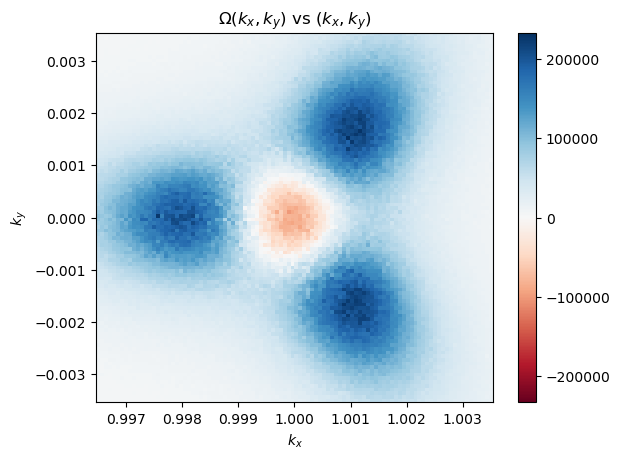

In [861]:
# set the relevant parameters
lambda = 0.99980
n = 20
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
bc_spacing = 10^(-3)
gap = 10
vF = 3/4
index = 1
shift = 0.0035
plot_bc_v3(lambda, n, vF, gap, kappa, V, shells, index, bc_spacing, shift)

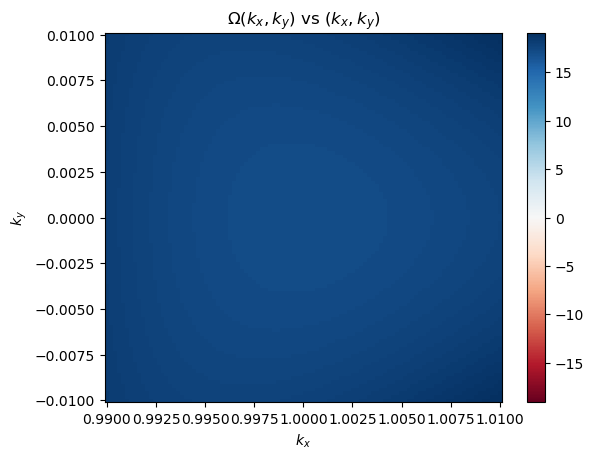

In [1258]:
# set the relevant parameters
lambda = 0.999579
n = 10
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
bc_spacing = 10^(-4)
gap = 10
vF = 0.7457
index = 1
shift = 0.01
plot_bc_v3(lambda, n, vF, gap, kappa, V, shells, index, bc_spacing, shift)

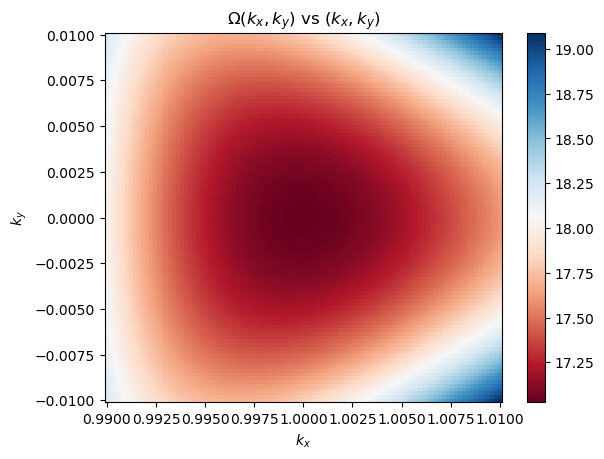

In [1268]:
# set the relevant parameters
lambda = 0.999579
n = 10
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
bc_spacing = 10^(-4)
gap = 10
vF = 0.7457
index = 1
shift = 0.01
plot_bc_v3(lambda, n, vF, gap, kappa, V, shells, index, bc_spacing, shift)

In [ ]:
# set the relevant parameters
lambda = 0.999579
n = 10
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
bc_spacing = 10^(-4)
gap = 10
vF = 0.7457
index = 1
shift = 0.01
plot_bc_v3(lambda, n, vF, gap, kappa, V, shells, index, bc_spacing, shift)

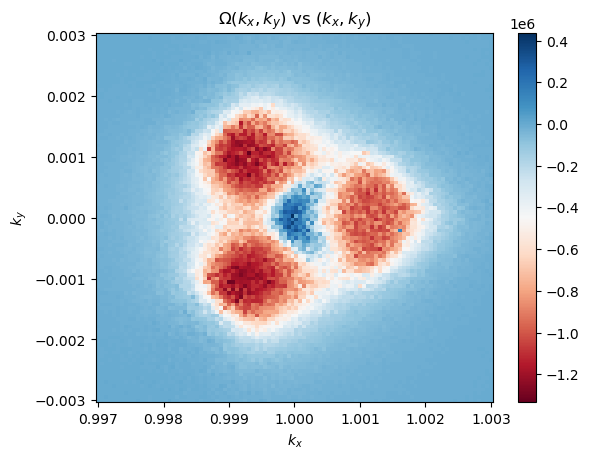

In [1295]:
# set the relevant parameters
lambda = 0.999804
n = 20
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
bc_spacing = 10^(-3)
gap = 10
vF = 0.7457
index = 1
shift = 0.003
plot_bc_v3(lambda, n, vF, gap, kappa, V, shells, index, bc_spacing, shift)

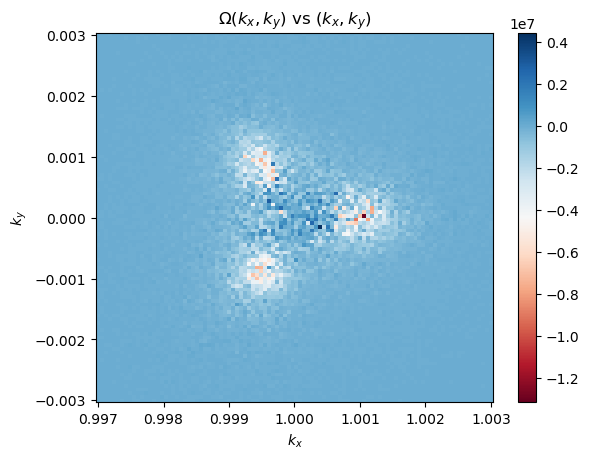

In [1294]:
# set the relevant parameters
lambda = 0.999804
n = 20
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
bc_spacing = 10^(-4)
gap = 10
vF = 0.7457
index = 1
shift = 0.003
plot_bc_v3(lambda, n, vF, gap, kappa, V, shells, index, bc_spacing, shift)

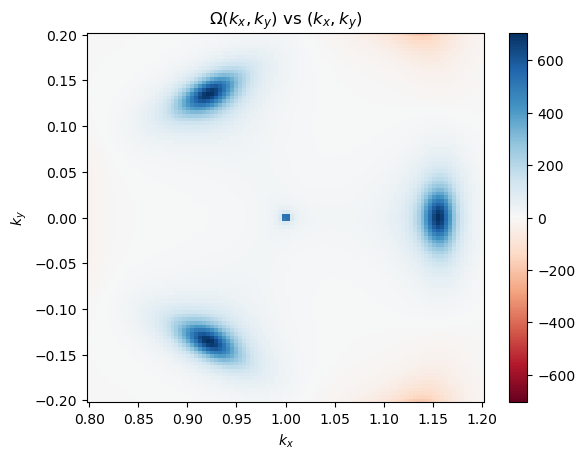

In [993]:
# set the relevant parameters
lambda = 0.999804
n = 20
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
bc_spacing = 10^(-3)
gap = 30
vF = 0.25
index = 1
shift = 0.2
plot_bc_v3(lambda, n, vF, gap, kappa, V, shells, index, bc_spacing, shift)

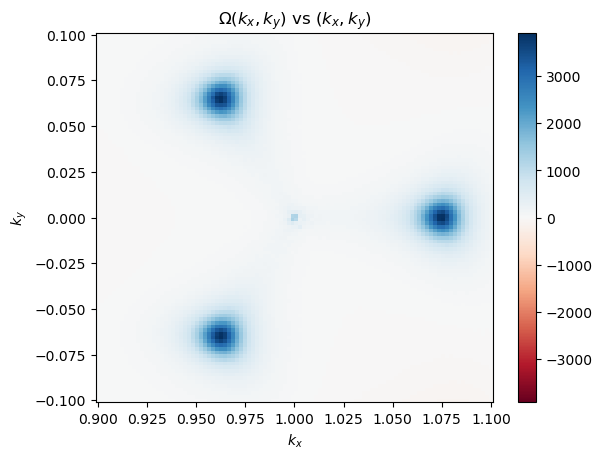

In [899]:
# set the relevant parameters
lambda = 0.999706
n = 20
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
bc_spacing = 10^(-4)
gap = 10
vF = 0.5
index = 1
shift = 0.1
plot_bc_v3(lambda, n, vF, gap, kappa, V, shells, index, bc_spacing, shift)

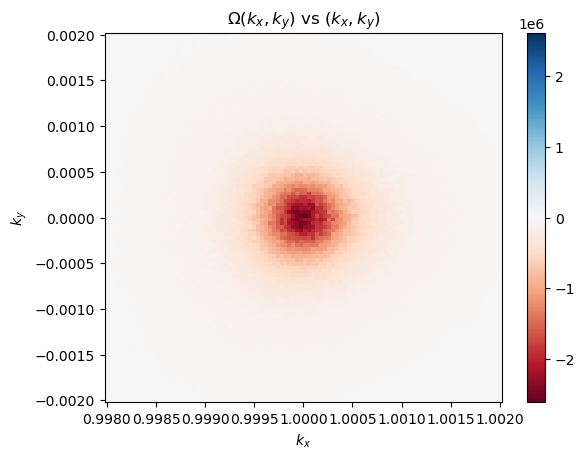

In [1066]:
# set the relevant parameters
lambda = 0.999776
n = 20
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
bc_spacing = 10^(-4)
gap = 10
vF = 0.7
index = 1
shift = 0.002
plot_bc_v3(lambda, n, vF, gap, kappa, V, shells, index, bc_spacing, shift)

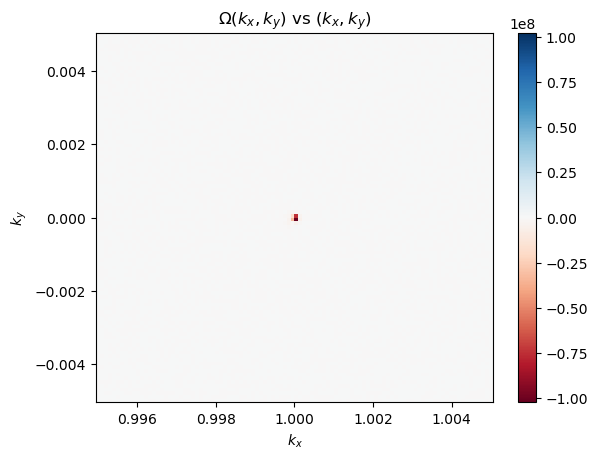

In [1070]:
# set the relevant parameters
lambda = 0.999917
n = 22
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
bc_spacing = 10^(-4)
ky = 0
llm = 0.995
ulm = 1.005
gap = 10

# alpha = 0.5 * lambda_alpha(kappa, lambda, V[1, 1], V[2, 2])
vF = 1
index = 1
shift = 0.005
plot_bc_v3(lambda, n, vF, gap, kappa, V, shells, index, bc_spacing, shift)

# More stuff

In [1235]:
function lambda_mBZ_phase_v3!(g1, g2, num_vertices, plaq_area, shell_parts, partitions, part_1s, dict, ham, spinors, grounds, k, lambda, n, gap, vF, kappa, V, shells, index, spacing)
    for j in 1:num_vertices
        x_new = k[1] + spacing * cos(2 * pi * (j - 1) / num_vertices)
        y_new = k[2] + spacing * sin(2 * pi * (j - 1) / num_vertices)
        ham = lambda_ham_v3!(g1, g2, shell_parts, partitions, part_1s, dict, ham, [x_new, y_new], lambda, n, gap, vF, V)
        grounds[j, :] = gauge_fix(normalize(eigvecs(Hermitian(ham))[:, index]))
        for m in 1:length(shell_parts)
            momentum = g1 * shell_parts[m][1] + g2 * shell_parts[m][2] + [x_new, y_new]
            spinors[j, m, :] = lambda_spinor(lambda, momentum)
        end
    end
    P = 0
    # P = 1
    for j in 1:num_vertices
        if j < num_vertices
            temp = angle(spinor_inner(grounds[j, :], grounds[j + 1, :], spinors[j, :, :], spinors[j + 1, :, :]))
            # P *= temp / abs(temp)
            P += temp
        else
            temp = angle(spinor_inner(grounds[j, :], grounds[1, :], spinors[j, :, :], spinors[1, :, :]))
            P += temp
            # P *= temp / abs(temp)
        end
    end
    return P
    # if abs(imag(P)) < 10^(-16)
    #     return -(angle(real(P))) / plaq_area
    # else
    #     return -angle(P) / plaq_area
    # end
end

function grid_phase_v3(grid, lambda, n, gap, vF, kappa, V, shells, index, spacing)
    num_vertices = 15
    mBZ_count = num_mBZ(shells)
    shell_parts = sgn_parts(shells)
    partitions = sgn_parts(shells - 1)
    part_1s = sgn_parts(1)
    dict = part_dict(shells)

    ham = zeros(ComplexF64, mBZ_count, mBZ_count)
    spinors = Array{ComplexF64}(undef, num_vertices, mBZ_count, 2)
    grounds = Array{ComplexF64}(undef, num_vertices, mBZ_count)
    plaq_area = area(spacing * sqrt(2), num_vertices)

    g1 = kappa * sqrt(3) * [-sqrt(3)/2, 1/2]
    g2 = kappa * sqrt(3) * [0, 1]

    gi = zeros(2)
    gj = zeros(2)

    berry_list = Array{Float64}(undef, size(grid, 1))

    for i in 1:size(grid, 1)
        berry_list[i] = lambda_mBZ_phase_v3!(g1, g2, num_vertices, plaq_area, shell_parts, partitions, part_1s, dict, ham, spinors, grounds, 
        grid[i, :], lambda, n, gap, vF, kappa, V, shells, index, spacing)
    end
    return berry_list
end

grid_phase_v3 (generic function with 1 method)

In [1238]:
# set the relevant parameters
lambda = 0.999804
n = 20
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
bc_spacing = 10^(-2)
gap = 0
vF = 3/4
index = 1

temp = grid_phase_v3(reshape([1, 0], (1, 2)), lambda, n, gap, vF, kappa, V, shells, index, spacing) / pi

1-element Vector{Float64}:
 1.99999999445301

In [1239]:
# set the relevant parameters
lambda =  0.999706
n = 20
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
bc_spacing = 10^(-6)
gap = 10
vF = 0.5
index = 1

temp = grid_phase_v3(reshape([1, 0], (1, 2)), lambda, n, gap, vF, kappa, V, shells, index, spacing) / pi

1-element Vector{Float64}:
 -2.996307883355638

In [1228]:
# set the relevant parameters
lambda = 0.99979
n = 20
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
bc_spacing = 10^(-6)
gap = 10
vF = 0.7
index = 1

temp = grid_phase_v3(reshape([1, 0], (1, 2)), lambda, n, gap, vF, kappa, V, shells, index, spacing) / pi

1-element Vector{Float64}:
 -0.48155943449714395

# Check Berry curvature

In [4]:
function V_agreement_v3(bc_spacing, lambda, n, gap, kappa, V, shells, q, index)
    V_scale = range(0.01, 0.1, 10^2)
    kappa_1 = kappa * [1, 0]
    mBZ_bc = Array{Float64}(undef, length(V_scale))
    patch_bc = Array{Float64}(undef, length(V_scale), 2)
    rel_error = Array{Float64}(undef, length(V_scale), 2)

    for j in 1:length(V_scale)
        mBZ_bc[j] = grid_bc_v3(reshape(kappa_1 .+ q, (1, 2)), lambda, n, gap, kappa, V_scale[j] * V, shells, index, bc_spacing)[1]

        v1 = V[1, 1]
        v2 = V[2, 2]
        delta = V_scale[j] * 1/2 * lambda_delta(kappa, lambda, v1, v2)
        alpha = V_scale[j] * 1/2 * lambda_alpha(kappa, lambda, v1, v2)
        vF = 4/sqrt(kappa^n + abs2(gap))
        patch_bc[j, 1] = lambda_patch_bc(reshape(q, (1, 2)), bc_spacing, lambda, kappa, vF, delta, alpha, index)[1]

        patch_bc[j, 2] = lambda_patch_bc(reshape(q, (1, 2)), bc_spacing, lambda, kappa, vF, delta, 0, index)[1]

        rel_error[j, 1] = abs(1 - (patch_bc[j, 1]/mBZ_bc[j]))
        rel_error[j, 2] = abs(1 - (patch_bc[j, 2]/mBZ_bc[j]))
    end
    fig, axs = plt.subplots(1,2,figsize=(15, 6))

    axs[1].plot(V_scale, mBZ_bc, label=L"\text{mBZ}")
    axs[1].plot(V_scale, patch_bc[:, 1], label=L"\text{3p}")

    axs[1].set_xlabel(L"$|V|$")
    axs[1].set_ylabel(L"$\Omega$")
    axs[1].set_title(L"$\Omega \text{ vs } |V|$")
    axs[1].legend()

    axs[2].plot(V_scale, rel_error[:, 1], label=L"$\alpha \neq 0$")
    axs[2].plot(V_scale, rel_error[:, 2], label=L"$\alpha = 0$")

    axs[2].set_xlabel(L"$|V|$")
    axs[2].set_ylabel(L"$\delta \Omega$")
    axs[2].set_title(L"$\delta \Omega \text{ vs } |V|$")
    axs[2].set_yscale("log")
    axs[2].legend()

    fig.tight_layout()

    fig
end

V_agreement_v3 (generic function with 1 method)

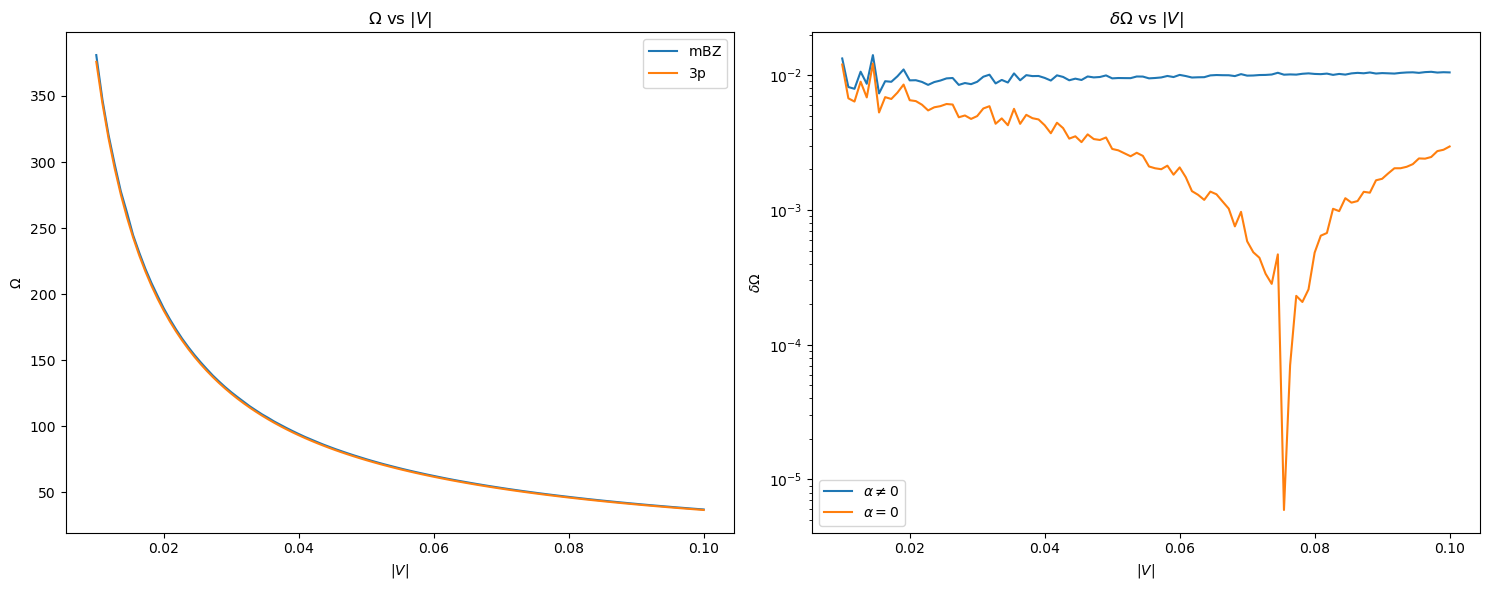

In [102]:
bc_spacing = 10^(-4)
lambda = 1
n = 16
gap = 1
kappa = 1
V = [[1, 0] [0, 1]]
shells = 5
q = [0, 0]
index = 1
V_agreement_v3(bc_spacing, lambda, n, gap, kappa, V, shells, q, index)

##  Check energies

In [182]:
function plot_gap_lambda_v3(q, n, gap_list, kappa, V, shells, llm, ulm)
    lambda_list = range(llm, ulm, 10^2)
    gaps = Array{Float64}(undef, length(lambda_list), length(gap_list))
    for i in 1:length(lambda_list)
        lambda = lambda_list[i]
        q1 = kappa * [1, 0]
        for j in 1:length(gap_list)
            gap = gap_list[j]
            ham = lambda_ham_v3(q1, lambda, n, gap, kappa, V, shells)
            vals = eigvals(Hermitian(ham))
            gaps[i, j] = log10(vals[2] - vals[1])
        end
    end
    fig, axs = plt.subplots(1,1,figsize=(15, 8))
    axs.set_xlabel(L"$\lambda$")
    axs.set_ylabel(L"$\log|\epsilon_0 - \epsilon_1|$")
    axs.set_title(L"$\log|\epsilon_0 - \epsilon_1|_{n} \text{ vs } \lambda$")
    for j in 1:length(gap_list)
        d = round(gap_list[j], sigdigits=2)
        axs.plot(lambda_list, gaps[:, j], label = raw"$d = $" * "$d")
    end
    axs.legend()
    fig
end

plot_gap_lambda_v3 (generic function with 1 method)

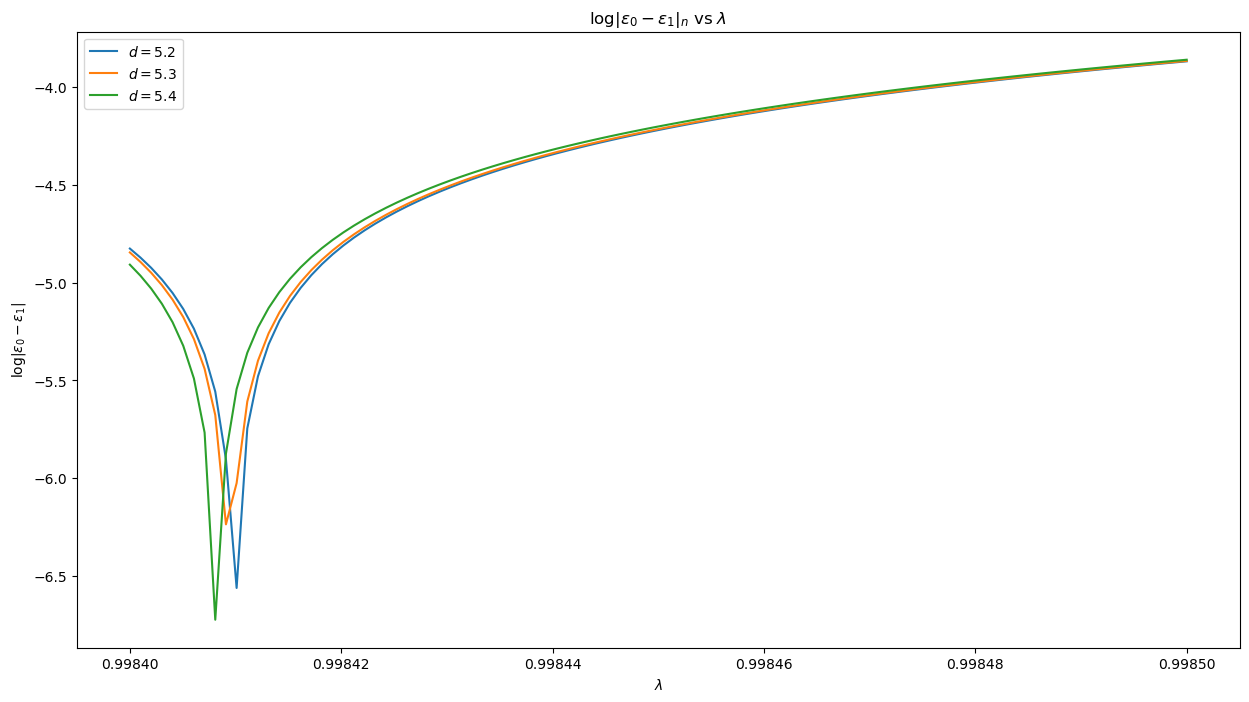

In [189]:
# set the relevant parameters
q = [0, 0]
n = 15
gap_list = [5.2, 5.2518169134621767, 5.4]
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
llm = 0.9984
ulm = 0.9985
plot_gap_lambda_v3(q, n, gap_list, kappa, V, shells, llm, ulm)

In [5]:
function plot_gap_kx_v3(ky, n, lambda_list, gap, kappa, V, shells, llm, ulm)
    kx_list = range(llm, ulm, 10^2)
    gaps = Array{Float64}(undef, length(kx_list), length(lambda_list))
    for i in 1:length(kx_list)
        kx = kx_list[i]
        q1 = [kx, ky]
        for j in 1:length(lambda_list)
            lambda = lambda_list[j]
            ham = lambda_ham_v3(q1, lambda, n, gap, kappa, V, shells)
            vals = eigvals(Hermitian(ham))
            gaps[i, j] = log10(vals[2] - vals[1])
        end
    end
    fig, axs = plt.subplots(1,1,figsize=(15, 8))
    axs.set_xlabel(L"$k_x$")
    axs.set_ylabel(L"$\log|\epsilon_0 - \epsilon_1|$")
    axs.set_title(L"$\log|\epsilon_0 - \epsilon_1|_{n} \text{ vs } k_x$")
    for j in 1:length(lambda_list)
        lambda = round(lambda_list[j], sigdigits=5)
        axs.plot(kx_list, gaps[:, j], label = raw"$\lambda = $" * "$lambda")
    end
    axs.legend()
    fig
end

plot_gap_kx_v3 (generic function with 1 method)

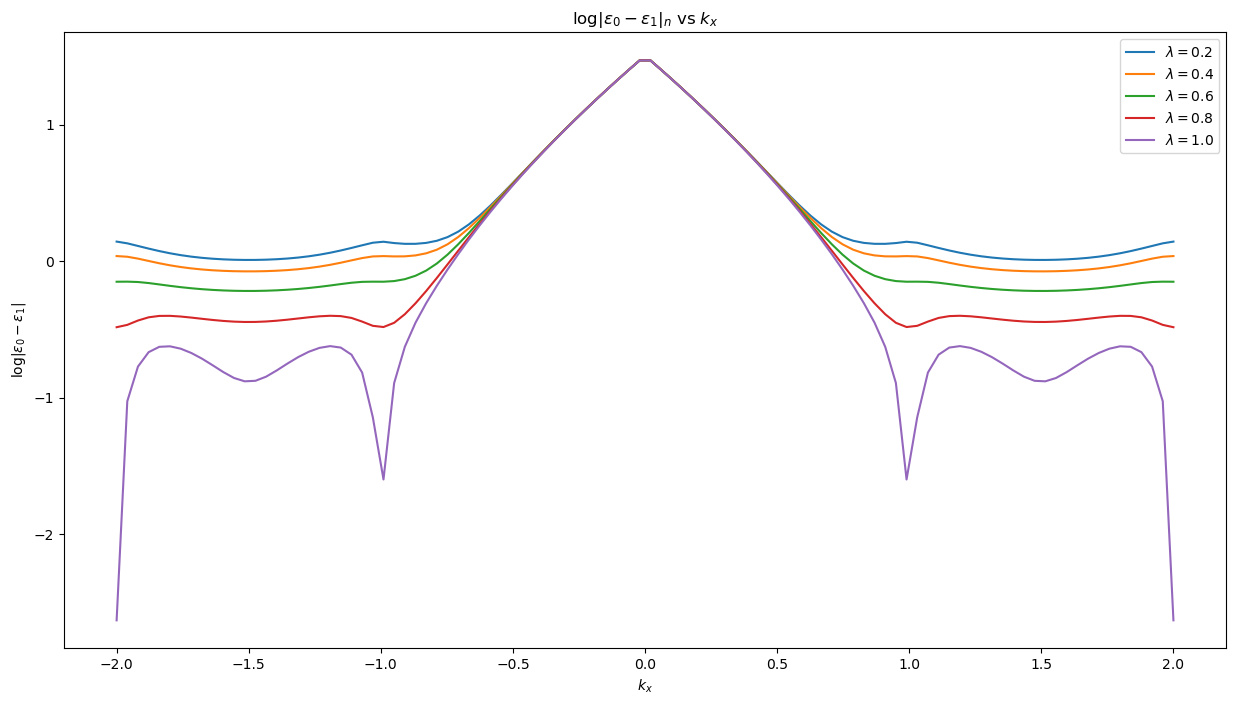

In [100]:
# set the relevant parameters
ky = 0
n = 15
lambda_list = [0.2, 0.4, 0.6, 0.8, 1]
gap = 0.75
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
llm = -2
ulm = 2
plot_gap_kx_v3(ky, n, lambda_list, gap, kappa, V, shells, llm, ulm)

In [247]:
function plot_energy_line_v3(lambda, n, gap, kappa, V, shells, spacing, ky, llm, ulm)
    n_pts = 10^2

    kx_list = range(llm, ulm, n_pts)

    energies = Array{Float64}(undef, n_pts, 3)

    for j in 1:(n_pts)
        k = [kx_list[j], ky]
        ham = lambda_ham_v3(k, lambda, n, gap, kappa, V, shells)
        energies[j, 1] = eigvals(Hermitian(ham))[1]
        energies[j, 2] = eigvals(Hermitian(ham))[2]
        energies[j, 3] = eigvals(Hermitian(ham))[3]
    end

    fig, axs = plt.subplots(1,figsize=(12, 8))
    axs.set_xlabel(L"$k_x$")
    axs.set_ylabel(L"$\epsilon$")
    axs.plot(kx_list, energies[:, 1], label = L"\epsilon_0")
    axs.plot(kx_list, energies[:, 2], label = L"\epsilon_1")
    axs.plot(kx_list, energies[:, 3], label = L"\epsilon_2")
    axs.legend()
    fig.tight_layout()
    
    fig
end

plot_energy_line_v3 (generic function with 1 method)

50


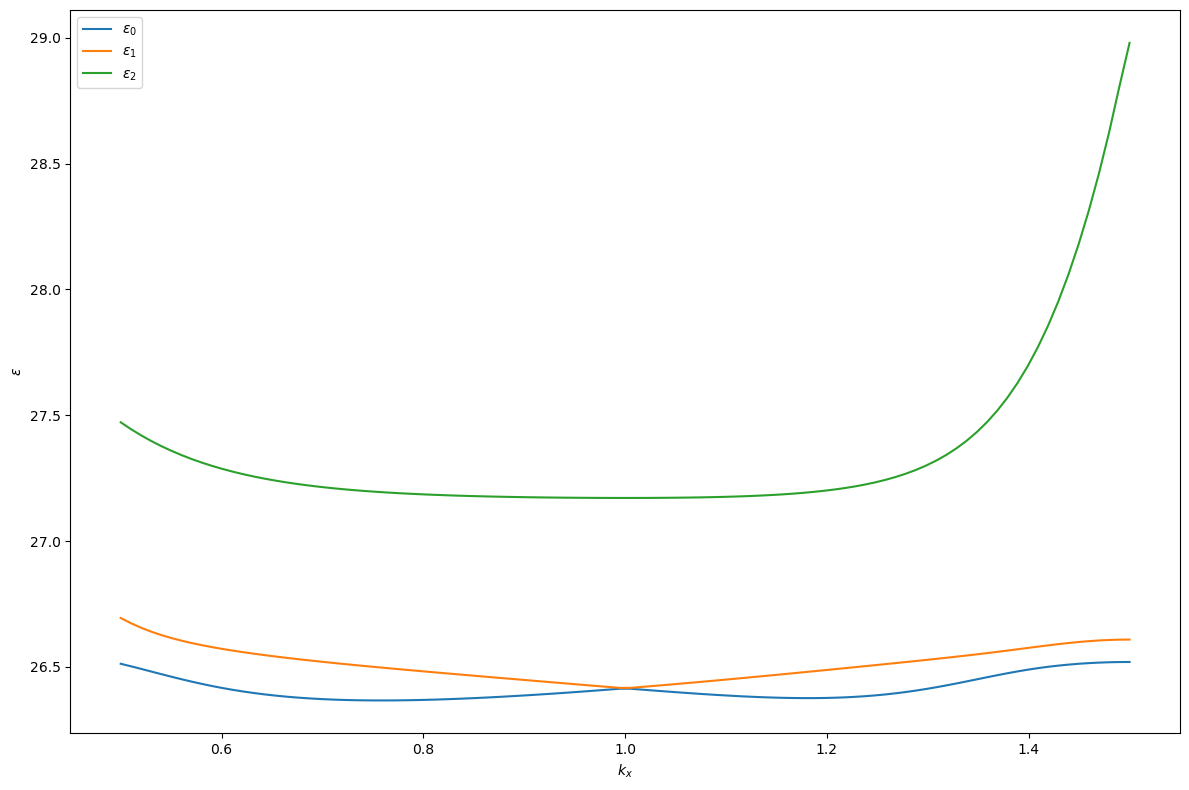

In [255]:
# set the relevant parameters
lambda = 0.99841
n = 15
kappa = 1
V = 1 * [[-1, 0] [0, -1]]
shells = 5
bc_spacing = 10^(-4)
ky = 0
llm = 0.5
ulm = 1.5

alpha = 0.5 * lambda_alpha(kappa, lambda, V[1, 1], V[2, 2])
gap = 1 * sqrt(4/abs2(alpha) - 1)
gap = 50
println(gap)

plot_energy_line_v3(lambda, n, gap, kappa, V, shells, bc_spacing, ky, llm, ulm)

50


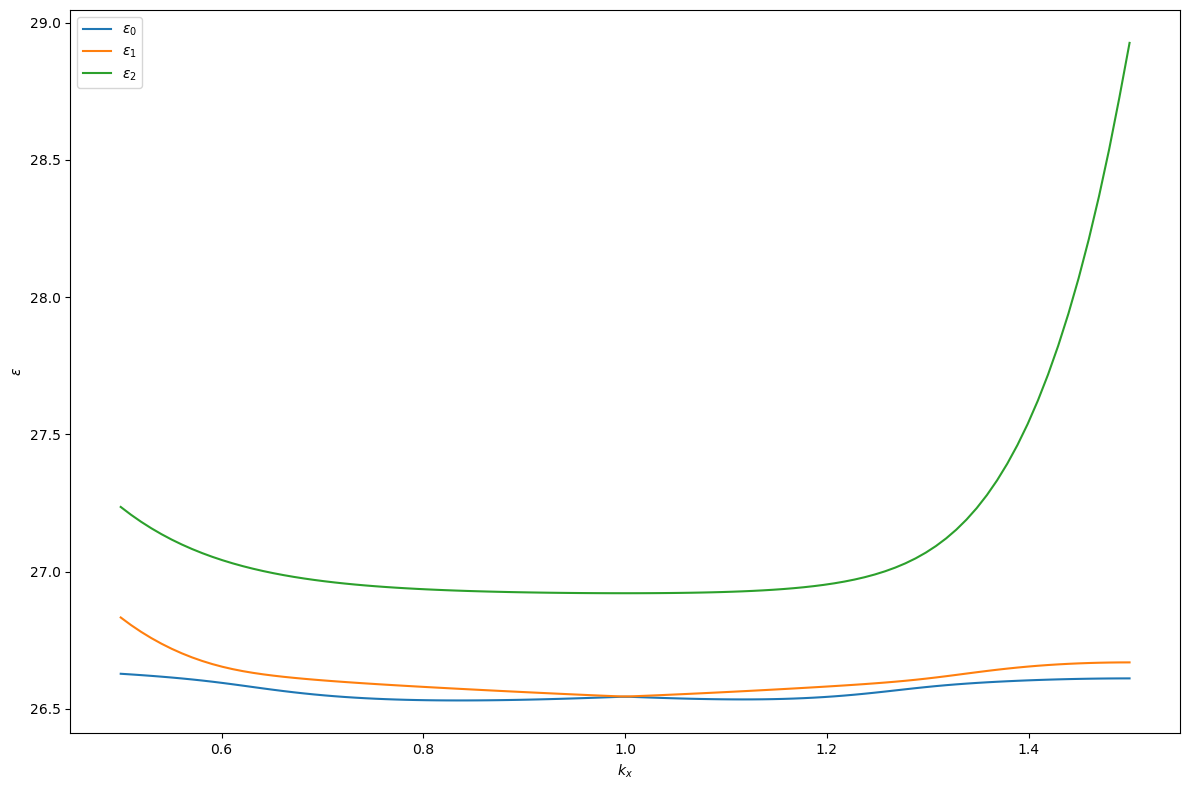

In [257]:
# set the relevant parameters
lambda = 0.99841
n = 15
kappa = 1
V = 0.5 * [[-1, 0] [0, -1]]
shells = 5
bc_spacing = 10^(-4)
ky = 0
llm = 0.5
ulm = 1.5

alpha = 0.5 * lambda_alpha(kappa, lambda, V[1, 1], V[2, 2])
gap = 1 * sqrt(4/abs2(alpha) - 1)
gap = 50
println(gap)

plot_energy_line_v3(lambda, n, gap, kappa, V, shells, bc_spacing, ky, llm, ulm)

## Berry plots

In [53]:
function plot_bc_v3(lambda, n, gap, kappa, V, shells, index, spacing, shift)
    n_pts = 10^2
    
    kx_list = range(kappa - shift, kappa + shift, n_pts)
    ky_list = shift * range(-1, 1, n_pts)
    grid = mesh_grid(kx_list, ky_list, Float64)

    # k_list = range(-kappa, kappa, n_pts)
    # grid = mesh_grid(k_list, k_list, Float64)


    bc_list = grid_bc_v3(grid, lambda, n, gap, kappa, V, shells, index, spacing)

    grid_new = reshape(grid, (n_pts, n_pts, 2))
    bc_list_new = reshape(bc_list, (n_pts, n_pts))

    bc_min = minimum(bc_list_new)
    bc_max = maximum(bc_list_new)
    bc_abs = maximum(abs.([bc_min, bc_max]))

    figure()
    xlabel(L"k_x")
    ylabel(L"k_y")
    title(L"\Omega(k_x, k_y) \text{ vs } (k_x, k_y)")
    pcolormesh(grid_new[:, :, 1], grid_new[:, :, 2], bc_list_new, cmap="RdBu", vmin = -bc_abs, vmax = bc_abs)
    colorbar()
    display(gcf())
end

plot_bc_v3 (generic function with 1 method)

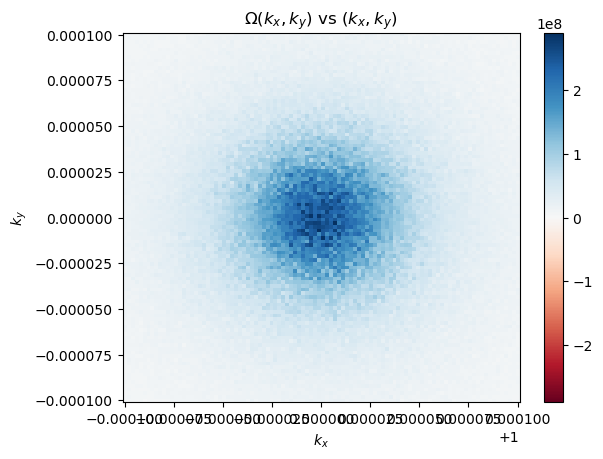

In [218]:
lambda = 0.99841
n = 15
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
spacing = 10^(-6)
shift = 0.0001
index = 1

alpha = 0.5 * lambda_alpha(kappa, lambda, V[1, 1], V[2, 2])
gap = 1 * sqrt(4/abs2(alpha) - 1)

plot_bc_v3(lambda, n, gap, kappa, V, shells, index, spacing, shift)

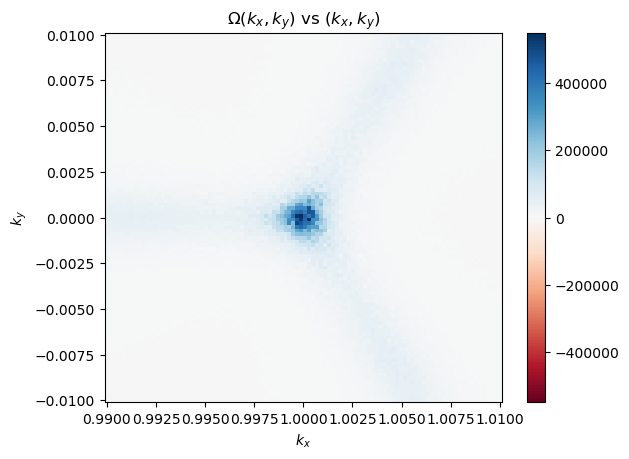

In [222]:
lambda = 0.99842
n = 15
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
spacing = 10^(-6)
shift = 0.01
index = 1

alpha = 0.5 * lambda_alpha(kappa, lambda, V[1, 1], V[2, 2])
gap = 1 * sqrt(4/abs2(alpha) - 1)

plot_bc_v3(lambda, n, gap, kappa, V, shells, index, spacing, shift)

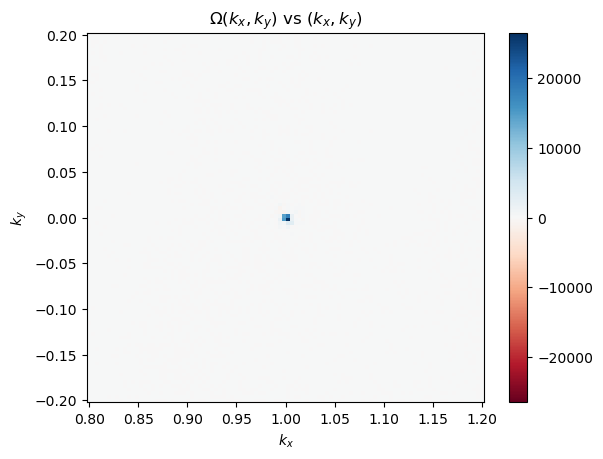

In [157]:
lambda = 1
n = 15
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
spacing = 10^(-4)
shift = 0.2
index = 1

alpha = 0.001 * lambda_alpha(kappa, lambda, V[1, 1], V[2, 2])
gap = 1 * sqrt(4/abs2(alpha) - 1)

plot_bc_v3(lambda, n, gap, kappa, V, shells, index, spacing, shift)

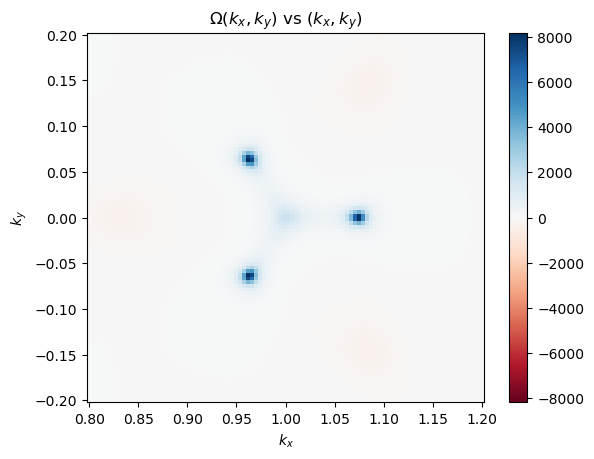

In [73]:
lambda = 1
n = 15
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
spacing = 10^(-4)
shift = 0.2
index = 1

alpha = 0.39 * lambda_alpha(kappa, lambda, V[1, 1], V[2, 2])
gap = 1 * sqrt(4/abs2(alpha) - 1)

plot_bc_v3(lambda, n, gap, kappa, V, shells, index, spacing, shift)

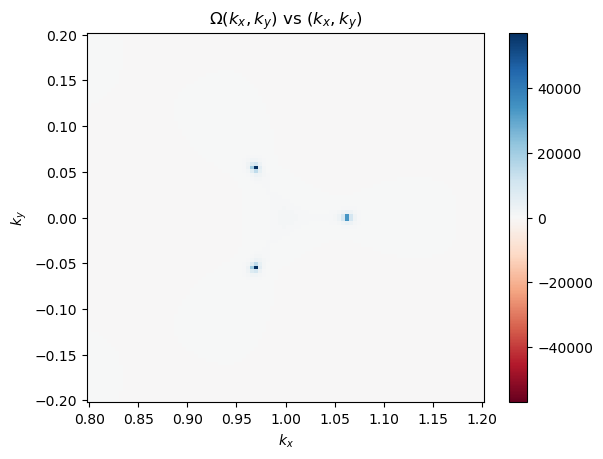

In [78]:
lambda = 1
n = 15
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
spacing = 10^(-4)
shift = 0.2
index = 1

alpha = 0.41 * lambda_alpha(kappa, lambda, V[1, 1], V[2, 2])
gap = 1 * sqrt(4/abs2(alpha) - 1)

plot_bc_v3(lambda, n, gap, kappa, V, shells, index, spacing, shift)

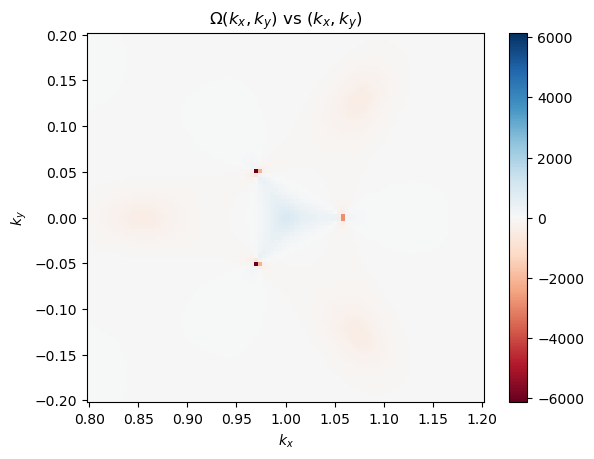

In [84]:
lambda = 1
n = 15
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
spacing = 10^(-4)
shift = 0.2
index = 1

alpha = 0.42 * lambda_alpha(kappa, lambda, V[1, 1], V[2, 2])
gap = 1 * sqrt(4/abs2(alpha) - 1)

plot_bc_v3(lambda, n, gap, kappa, V, shells, index, spacing, shift)

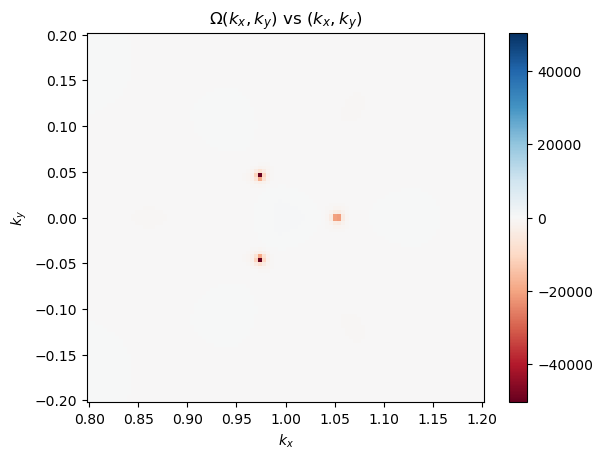

In [77]:
lambda = 1
n = 15
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
spacing = 10^(-4)
shift = 0.2
index = 1

alpha = 0.43 * lambda_alpha(kappa, lambda, V[1, 1], V[2, 2])
gap = 1 * sqrt(4/abs2(alpha) - 1)

plot_bc_v3(lambda, n, gap, kappa, V, shells, index, spacing, shift)

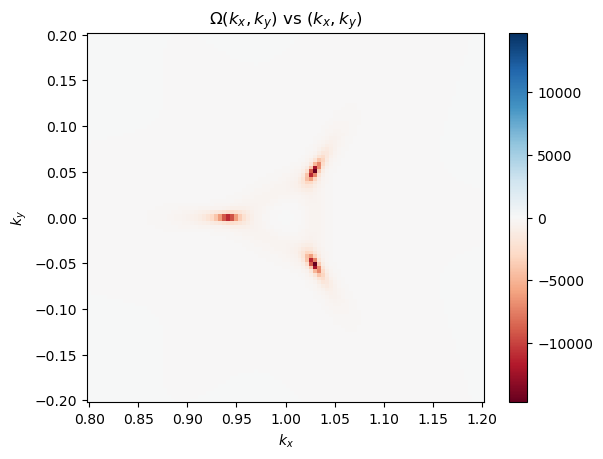

In [74]:
lambda = 1
n = 15
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
spacing = 10^(-4)
shift = 0.2
index = 1

alpha = 0.5 * lambda_alpha(kappa, lambda, V[1, 1], V[2, 2])
gap = 1 * sqrt(4/abs2(alpha) - 1)

plot_bc_v3(lambda, n, gap, kappa, V, shells, index, spacing, shift)

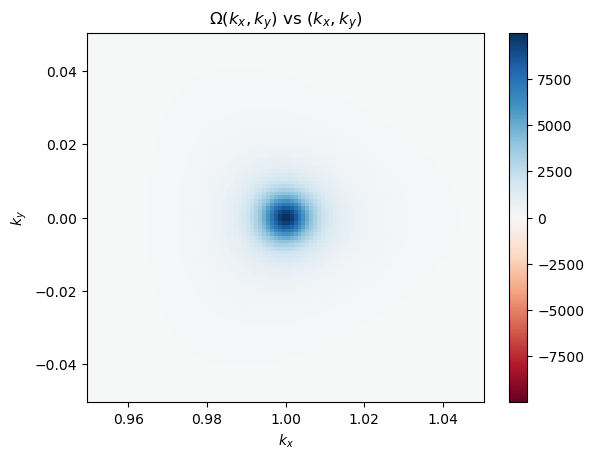

In [28]:
lambda = 1
n = 15
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
spacing = 10^(-4)
shift = 0.05
index = 1

alpha = 1/2 * lambda_alpha(kappa, lambda, V[1, 1], V[2, 2])
gap = 2 * sqrt(4/abs2(alpha) - 1)

plot_bc_v3(lambda, n, gap, kappa, V, shells, index, spacing, shift)

## Berry curvature line cuts

In [1281]:
function plot_ang_bc_v3(gap, vF, n, lambda, kappa, V, shells, index, spacing, k_mag)
    n_pts = 10^2
    
    bc_list = Array{Float64}(undef, n_pts)

    ang_list = range(-pi, pi, n_pts)
    
    for j in 1:length(ang_list)
        point = reshape([kappa, 0] + k_mag * [cos(ang_list[j]), sin(ang_list[j])], (1, 2))
        bc_list[j] = grid_bc_v3(point, lambda, n, gap, vF, kappa, V, shells, index, spacing)[1]
    end

    fig, axs = plt.subplots(1,1,figsize=(15, 6))
    axs.plot(ang_list/pi, bc_list)
    axs.set_xlabel(L"$\text{arg}(k)/ \pi$")
    axs.set_ylabel(L"$\Omega$")

    fig.tight_layout()
    fig
end

plot_ang_bc_v3 (generic function with 2 methods)

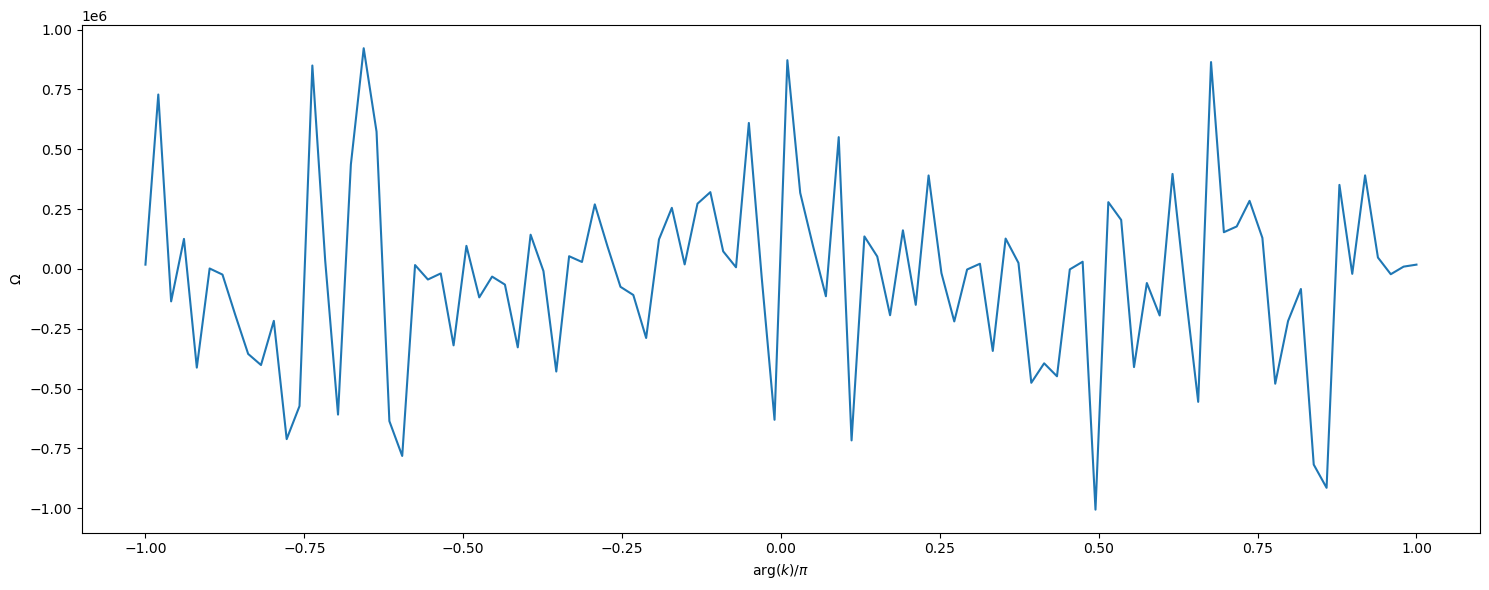

In [1300]:
lambda = 0.999804
n = 20
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
spacing = 10^(-5)
index = 1

vF = 0.7457
gap = 10

k_mag = 0.003

plot_ang_bc_v3(gap, vF, n, lambda, kappa, V, shells, index, spacing, k_mag)

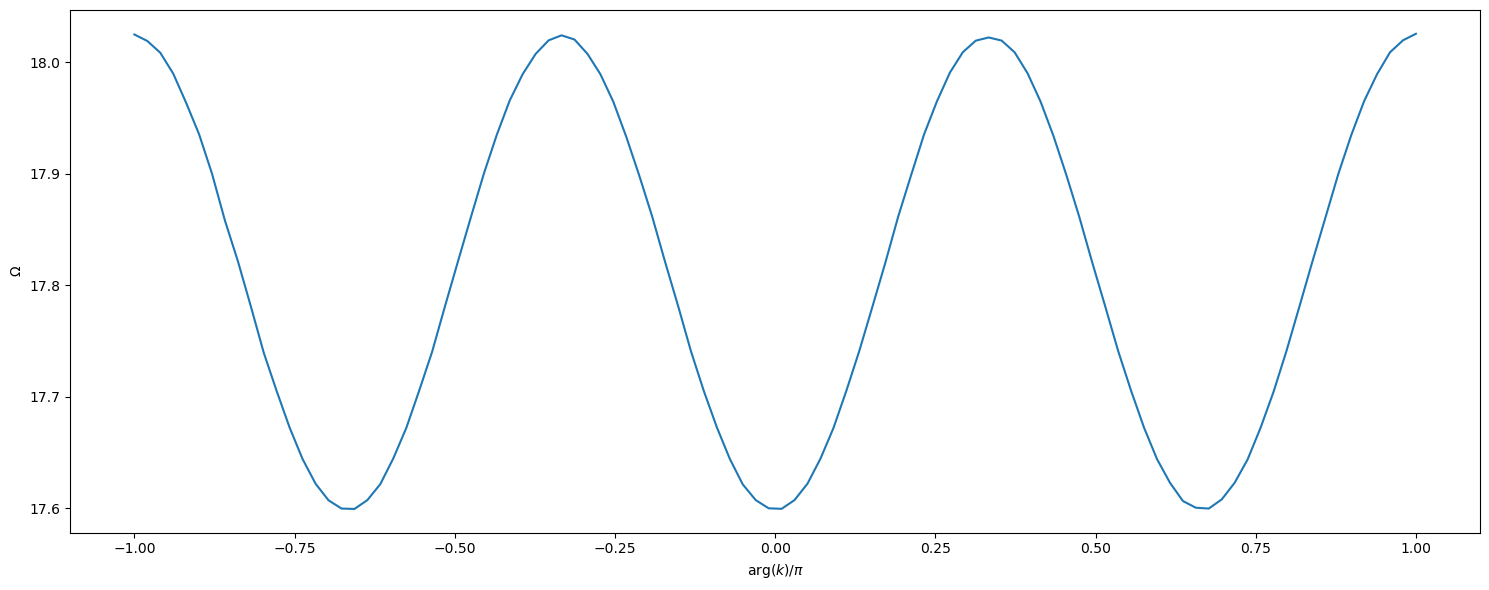

In [1285]:
lambda = 0.999579
n = 10
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
spacing = 10^(-5)
index = 1

vF = 0.7457
gap = 10

k_mag = 0.01

plot_ang_bc_v3(gap, vF, n, lambda, kappa, V, shells, index, spacing, k_mag)